# We will try tracking the hands with just 6 landmarks, which will be a 6 x 3 x 2 = 36 length vector for each time step. 

In [1]:
import cv2, os 
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

In [2]:
import mediapipe as mp 
from PIL import Image as im 
import mediapipe as mp

def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    """Only give 6 landmarks"""

    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 12
    Y_locations = [0] * 12
    Z_locations = [0] * 12

    if results.multi_hand_landmarks:
        x = y = z = 0 
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                if i not in [0, 4, 8, 12, 16, 20]: continue 
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y 
                Z_locations[z] = landmark.z
                x += 1; y += 1; z +=1; 
            
    hands.close()
    return np.concatenate([X_locations, Y_locations, Z_locations]) 

In [ ]:
"""read in all of the frames"""

SECONDS_TO_DETECT = 2 # in seconds

import os, cv2
from tqdm import tqdm 
import numpy as np

ARMFLAPPING_VIDEOS = []
CONTROL_VIDEOS = []
ARMFLAPPING_FPS = [] # store the FPS of all armflapping videos 
CONTROL_FPS = [] # store the FPS of all control videos 
for video_name in tqdm(os.listdir('behavior_data/shorter_armflapping'), desc = "armflapping_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/shorter_armflapping/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break  
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image) 
        
        ARMFLAPPING_VIDEOS.append(FRAMES)
        ARMFLAPPING_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")

for video_name in tqdm(os.listdir('behavior_data/shorter_control'), desc = "control_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/shorter_control/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break 
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image)
        
        CONTROL_VIDEOS.append(FRAMES)
        CONTROL_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")
    
len(ARMFLAPPING_VIDEOS), len(CONTROL_VIDEOS)

In [ ]:
# get the locations of all of the videos 

ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS = [], []
for FRAMES in tqdm(ARMFLAPPING_VIDEOS) :
    locs = []
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    ARMFLAPPING_LOCATIONS.append(locs)

for FRAMES in tqdm(CONTROL_VIDEOS):  
    locs = []
    
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    CONTROL_LOCATIONS.append(locs)

In [ ]:
N = min([len(locs) for locs in [ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS]])
ARMFLAPPING_LOCATIONS = ARMFLAPPING_LOCATIONS[:N]
CONTROL_LOCATIONS = CONTROL_LOCATIONS[:N]
ARMFLAPPING_LOCATIONS = np.array(ARMFLAPPING_LOCATIONS)
CONTROL_LOCATIONS = np.array(CONTROL_LOCATIONS)

# we can create a padding function in order to pad 
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

padded_armflapping_locations = ARMFLAPPING_LOCATIONS
padded_control_locations = CONTROL_LOCATIONS
padded_armflapping_locations = pad(padded_armflapping_locations, maxlen = 90)
padded_control_locations = pad(padded_control_locations, maxlen = 90)
print(padded_control_locations.shape, padded_armflapping_locations.shape)
assert padded_armflapping_locations.shape == padded_control_locations.shape 

In [ ]:
from sklearn.model_selection import train_test_split

def generate_data(ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS): 
    ARMFLAPPING_LABELS = np.ones(ARMFLAPPING_LOCATIONS.shape[0])
    CONTROL_LABELS = np.zeros(CONTROL_LOCATIONS.shape[0])
    
    # concatenate 
    data = np.concatenate([ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS])
    labels = np.concatenate([ARMFLAPPING_LABELS, CONTROL_LABELS])
    
    return data, labels 

X, y = generate_data(padded_armflapping_locations, padded_control_locations)

In [3]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

# we can create a padding function in order to pad 
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)
    
def predict_on_video(model, path): 
    LOCATIONS = []
    cap = cv2.VideoCapture(path)
    while cap.isOpened():
        _, frame = cap.read()
        if not _: break 

        LOCATIONS.append(hand_locations(frame))
    LOCATIONS = pad(np.array([LOCATIONS]),maxlen=90)
    return model.predict(LOCATIONS)


In [4]:
import random 
import tensorflow as tf 
tf.config.run_functions_eagerly(True)
from tensorflow.keras.callbacks import ReduceLROnPlateau

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :12] 
        Y_locations = X[:,  12:24] 
        Z_locations = X[:, 24:]
        
        mask = tf.not_equal(Y_locations, 0) 
        nonzero_Y_locations = tf.boolean_mask(Y_locations, mask) # contains all nonzero elements of Y_locations 
    
        maximum = tf.math.reduce_max(nonzero_Y_locations)
        minimum = tf.math.reduce_min(nonzero_Y_locations)

        can_move_up = 1 - maximum 
        can_move_down = minimum 
        mask = tf.cast(mask, tf.float32)
    
        if tf.random.uniform((1,)) > 0.5: 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:,  12:24].assign(X[:,  12:24] + mask * tf.ones_like(X[:,  12:24]) * move_up)
        else: 

            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:,  12:24].assign(X[:,  12:24] - mask * tf.ones_like(X[:,  12:24]) * move_down)

        mask = tf.not_equal(X_locations, 0) 
        nonzero_X_locations = tf.boolean_mask(X_locations, mask) 

        maximum = tf.math.reduce_max(nonzero_X_locations)
        minimum = tf.math.reduce_min(nonzero_X_locations)
            
        can_move_right = 1- maximum
        can_move_left = minimum 
        mask = tf.cast(mask, tf.float32)

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :12].assign(X[:, :12] + mask * tf.ones_like(X[:, :12]) * move_right)

        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :12].assign(X[:, :12] - mask * tf.ones_like(X[:, :12]) * move_left)

        mask = tf.not_equal(Z_locations, 0) 
        nonzero_Z_locations = tf.boolean_mask(Z_locations, mask)

        maximum = tf.math.reduce_max(nonzero_Z_locations)
        minimum = tf.math.reduce_min(nonzero_Z_locations)
        mask = tf.cast(mask, tf.float32)

        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move far
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 24:].assign(X[:, 24:] + mask * tf.ones_like(X[:, 24:]) * move_far)
        else: 
            # move close 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 24:].assign(X[:, 24:] - mask * tf.ones_like(X[:, 24:]) * move_close)

        return X

class Augmenter(tf.keras.layers.Layer): 
    def __init__(self, rotation_range = None): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180) + X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) - X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vocab_size': 0,
            'num_layers': 1,
            'units': 0,
            'd_model': 1,
            'num_heads': 1,
            'dropout': 0,
        })
        return config
        
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            if self.rotation_range: 
                X = tf.map_fn(self._rotate, X)
            return X
        else: 
            return X 

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.9):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.9*100))   
            self.model.stop_training = True  
        

In [5]:
import pickle
import os
import numpy as np 

X = []
y = []

for file in os.listdir('six_point_folds'): 
    with open(f"six_point_folds/{file}", 'rb') as f: 
        X_i, y_i = pickle.load(f)
        X.append(X_i)
        y.append(y_i)

X = np.array(X)
y = np.array(y)

In [6]:
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

In [ ]:
from scipy import interpolate
def adjust(frame_matrix): 
    assert len(frame_matrix.shape) == 2
    rows, columns = frame_matrix.shape
    for column in range(columns): 
        loc_dimension = frame_matrix[column]
        x = np.arange(0, rows, 1)
        idx = np.nonzero(loc_dimension)
        if len(idx) == 1: 
            continue 
        interp_func = interpolate.interp1d(x[idx], loc_dimension[idx], kind='cubic', fill_value = "extrapolate")
        frame_matrix[:, column] = interp_func(x) 
    return frame_matrix

def interp_X(X): 
    temp_X = np.concatenate([X_i for X_i in X])
    temp_X =  np.array([adjust(temp_X_i) for temp_X_i in temp_X])
    print(temp_X.shape)
    return temp_X.reshape(X.shape)

In [7]:
def plot_roc_auroc(base_fpr, TPRs, FPRs, aurocs): 
    

    for i, (tpr, fpr) in enumerate(zip(TPRs, FPRs)): 
        plt.plot(base_fpr, tpr, label = f"fold {i + 1}")

    mean_tpr = np.mean(TPRs, axis=0)
    plt.plot(base_fpr, mean_tpr, label = "average of folds")
    
    std_tpr = np.std(TPRs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve across folds')
    plt.legend(loc="lower right")
    plt.show()

    # plot the auroc curves 
    mean_auroc = sum(aurocs) / len(aurocs)
    descriptions = [f"fold {i + 1}" for i in range(len(aurocs))] + ["average fold"]
    aurocs.append(mean_auroc)
    plt.bar(descriptions, aurocs, color = "green")
    plt.xlabel("Fold")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across folds")
    plt.show() 

    return mean_tpr, mean_auroc

def plot_meta_roc_auroc(average_aurocs, average_tprs, base_fpr): 
    meta_avg_tpr = np.mean(average_tprs, axis = 0) 
    meta_avg_auroc = sum(average_aurocs) / len(average_aurocs)
    
    for i, average_tpr in enumerate(average_tprs): 
        plt.plot(base_fpr, average_tpr, label = f"run {i + 1}")
    
    plt.plot(base_fpr, meta_avg_tpr, label = "average of runs")
    
    std_tpr = np.std(average_tprs, axis=0)
    tprs_upper = np.minimum(meta_avg_tpr + std_tpr, 1)
    tprs_lower = np.maximum(meta_avg_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3, label=r'$\pm$ 1 std. dev.')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve across Runs (No Aug)')
    plt.legend(loc="lower right")
    plt.show()

    descriptions = [f"{i + 1}" for i in range(len(average_aurocs))] + ["avg"]
    average_aurocs.append(meta_avg_auroc)
    plt.bar(descriptions, average_aurocs, color = "green")
    plt.xlabel("Run Number")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across Runs (No Aug)")
    plt.show()

In [8]:
from glob import glob
from tqdm import tqdm 
from scipy import interp
import tensorflow_addons as tfa
from sklearn.metrics import roc_curve, roc_auc_score
AVERAGE_TPRS, AVERAGE_AUROCS = [], [] 
def cross_validate(make_model, epochs = 50, callbacks=[]):
    model = make_model()

    base_fpr = np.linspace(0, 1, 101)
    FPRS, TPRS, AUROCS = [], [], []
    for i in range(X.shape[0]): 
        model = make_model()

        X_test, y_test = X[i], y[i]
        X_train = np.concatenate([X_j for j, X_j in enumerate(X) if i != j])
        y_train = np.concatenate([y_j for j, y_j in enumerate(y) if i != j])

        try:
            os.remove("best.h5") 
        except Exception as e: 
            pass 

        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)
        
        try: 
            model.load_weights("best.h5")
        except Exception as e: 
            pass 

        # evaluate again 
        model.evaluate(X_test, y_test)
        
        # plot accuracy and loss 
        plot(history)

        # get this information  
        y_pred = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred) 
        FPRS.append(fpr)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0 
        TPRS.append(tpr)
        AUROCS.append(roc_auc_score(y_test, y_pred))

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"prediction for video {file} is {predict_on_video(model, file)}")

    mean_tpr, mean_auroc = plot_roc_auroc(base_fpr, TPRS, FPRS, AUROCS) 
    AVERAGE_TPRS.append(mean_tpr) 
    AVERAGE_AUROCS.append(mean_auroc)

In [17]:
import random 
def shuffle(X, y, seed = None):
    if seed == None:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 36)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y
X, y = shuffle(X, y, seed = 68)

In [11]:
def f1(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p+r+tf.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return tf.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p+r+tf.keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - tf.math.reduce_mean(f1)

In [9]:
def make_model(): 
    model = tf.keras.models.Sequential([
        #Augmenter(), 
        tf.keras.layers.LSTM(64, return_sequences=False, input_shape = (None, 36)), 
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(1, activation = 'sigmoid') 
    ]) 

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

2021-08-01 17:20:43.173684: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-01 17:20:43.885918: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/75
3/3 [==============================] - 1s 173ms/step - loss: 0.6821 - accuracy: 0.4750 - precision_1: 0.4754 - recall_1: 0.7436 - val_loss: 0.6661 - val_accuracy: 0.6000 - val_precision_1: 1.0000 - val_recall_1: 0.2727
Epoch 2/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6949 - accuracy: 0.5875 - precision_1: 0.5750 - recall_1: 0.5897 - val_loss: 0.6941 - val_accuracy: 0.6500 - val_precision_1: 0.6667 - val_recall_1: 0.7273
Epoch 3/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6122 - accuracy: 0.7625 - precision_1: 0.7500 - recall_1: 0.7692 - val_loss: 0.6372 - val_accuracy: 0.6500 - val_precision_1: 0.8333 - val_recall_1: 0.4545
Epoch 4/75
3/3 [==============================] - 0s 156ms/step - loss: 0.5720 - accuracy: 0.7500 - precision_1: 0.8519 - recall_1: 0.5897 - val_loss: 0.5675 - val_accuracy: 0.7500 - val_precision_1: 0.8000 - val_recall_1: 0.7273
Epoch 5/75
3/3 [==============================] - 0s 150ms/step - loss: 0.5906 -

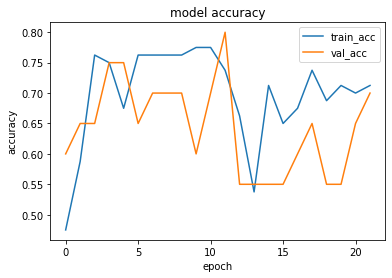

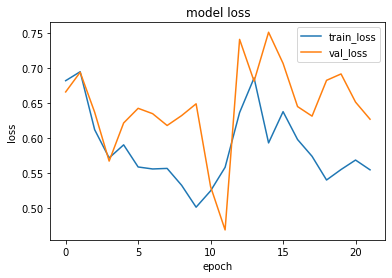

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
1it [00:00, 3536.51it/s]


prediction for video armflapping_1.mov is [[0.2337515]]


1it [00:00, 13357.66it/s]


prediction for video armflapping_3.mov is [[0.88527167]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.80514234]]


1it [00:00, 9177.91it/s]


prediction for video control_1.mov is [[0.5574217]]


1it [00:00, 12671.61it/s]


prediction for video control_2.mov is [[0.30925894]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.05252793]]
Epoch 1/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6920 - accuracy: 0.5625 - precision_2: 0.5593 - recall_2: 0.7857 - val_loss: 0.6695 - val_accuracy: 0.7500 - val_precision_2: 0.8000 - val_recall_2: 0.5000
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6308 - accuracy: 0.7500 - precision_2: 0.7750 - recall_2: 0.7381 - val_loss: 0.6977 - val_accuracy: 0.6500 - val_precision_2: 0.5385 - val_recall_2: 0.8750
Epoch 3/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6308 - accuracy: 0.6375 - precision_2: 0.6585 - recall_2: 0.6429 - val_loss: 0.6188 - val_accuracy: 0.6500 - val_precision_2: 0.5556 - val_recall_2: 0.6250
Epoch 4/75
3/3 [==============================] - 0s 130ms/step - loss: 0.5717 - accuracy: 0.7625 - precision_2: 0.7949 - recall_2: 0.7381 - val_loss: 0.6499 - val_accuracy: 0.7000 - val_precision_2: 0.6000 - val_recall_2: 0.7500
Epoch 5/75
3/3 [===========

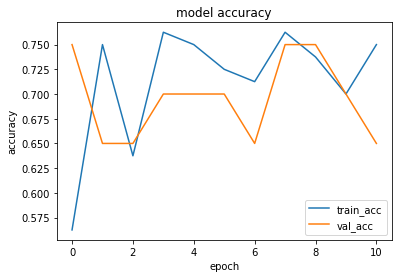

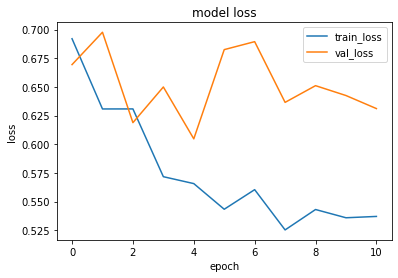

1it [00:00, 11650.84it/s]


prediction for video armflapping_1.mov is [[0.58582926]]


1it [00:00, 14217.98it/s]


prediction for video armflapping_3.mov is [[0.70952296]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_2.mov is [[0.7601058]]


In [10]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6853 - accuracy: 0.5125 - precision_21: 0.4912 - recall_21: 0.7368 - val_loss: 0.6962 - val_accuracy: 0.5000 - val_precision_21: 1.0000 - val_recall_21: 0.1667
Epoch 2/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6549 - accuracy: 0.6625 - precision_21: 0.8235 - recall_21: 0.3684 - val_loss: 0.5812 - val_accuracy: 0.8500 - val_precision_21: 0.8462 - val_recall_21: 0.9167
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6428 - accuracy: 0.7000 - precision_21: 0.6842 - recall_21: 0.6842 - val_loss: 0.5534 - val_accuracy: 0.7000 - val_precision_21: 0.6875 - val_recall_21: 0.9167
Epoch 4/75
3/3 [==============================] - 0s 125ms/step - loss: 0.5966 - accuracy: 0.7000 - precision_21: 0.6458 - recall_21: 0.8158 - val_loss: 0.5954 - val_accuracy: 0.6500 - val_precision_21: 0.6667 - val_recall_21: 0.8333
Epoch 5/75
3/3 [==============================] - 0s 131ms/step 

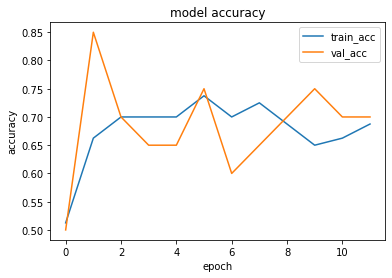

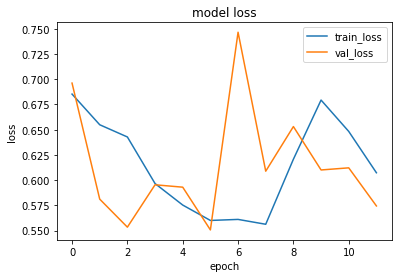

1it [00:00, 17260.51it/s]


prediction for video armflapping_1.mov is [[0.50020856]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.5099892]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.5368716]]


1it [00:00, 17549.39it/s]


prediction for video control_1.mov is [[0.4717824]]


1it [00:00, 19239.93it/s]


prediction for video control_2.mov is [[0.45745605]]


1it [00:00, 17331.83it/s]


prediction for video control_3.mov is [[0.4527576]]
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6632 - accuracy: 0.6750 - precision_22: 0.6591 - recall_22: 0.7250 - val_loss: 0.7476 - val_accuracy: 0.5000 - val_precision_22: 0.5000 - val_recall_22: 0.1000
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6409 - accuracy: 0.6625 - precision_22: 0.7826 - recall_22: 0.4500 - val_loss: 0.8312 - val_accuracy: 0.5500 - val_precision_22: 0.5294 - val_recall_22: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6567 - accuracy: 0.6375 - precision_22: 0.5873 - recall_22: 0.9250 - val_loss: 0.7143 - val_accuracy: 0.7000 - val_precision_22: 0.7500 - val_recall_22: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 127ms/step - loss: 0.5968 - accuracy: 0.7125 - precision_22: 0.7742 - recall_22: 0.6000 - val_loss: 0.6513 - val_accuracy: 0.7500 - val_precision_22: 0.7273 - val_recall_22: 0.8000
Epoch 5/75
3

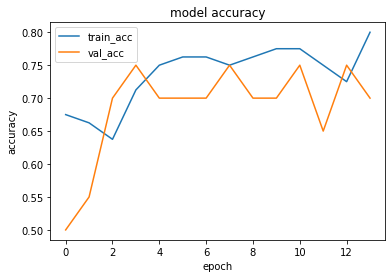

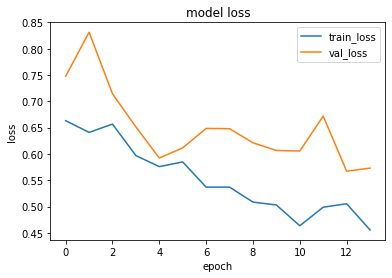

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.6210006]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_3.mov is [[0.6566422]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.77849936]]


1it [00:00, 18236.10it/s]


prediction for video control_1.mov is [[0.3711346]]


1it [00:00, 18808.54it/s]


prediction for video control_2.mov is [[0.30382937]]


1it [00:00, 18558.87it/s]


prediction for video control_3.mov is [[0.26163125]]
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6681 - accuracy: 0.6000 - precision_23: 0.6538 - recall_23: 0.4250 - val_loss: 0.6545 - val_accuracy: 0.5500 - val_precision_23: 0.5263 - val_recall_23: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6371 - accuracy: 0.5750 - precision_23: 0.5500 - recall_23: 0.8250 - val_loss: 0.6388 - val_accuracy: 0.7500 - val_precision_23: 0.8571 - val_recall_23: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.5983 - accuracy: 0.7500 - precision_23: 0.7500 - recall_23: 0.7500 - val_loss: 0.6030 - val_accuracy: 0.7000 - val_precision_23: 0.7500 - val_recall_23: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 125ms/step - loss: 0.5969 - accuracy: 0.7000 - precision_23: 0.6818 - recall_23: 0.7500 - val_loss: 0.5907 - val_accuracy: 0.7500 - val_precision_23: 0.8571 - val_recall_23: 0.6000
Epoch 5/75


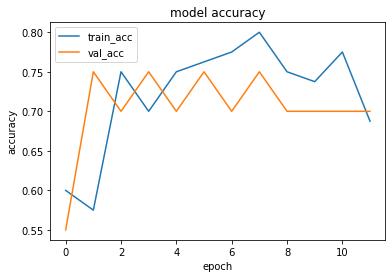

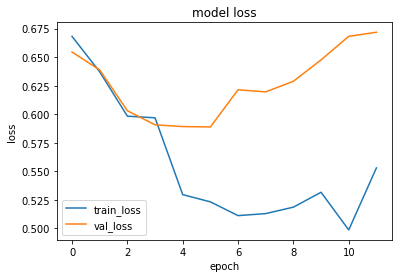

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.33872944]]


1it [00:00, 15827.56it/s]


prediction for video armflapping_3.mov is [[0.41439974]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_2.mov is [[0.58365285]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.27455848]]


1it [00:00, 16448.25it/s]


prediction for video control_2.mov is [[0.27911]]


1it [00:00, 17623.13it/s]


prediction for video control_3.mov is [[0.2585822]]
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6981 - accuracy: 0.4500 - precision_24: 0.4762 - recall_24: 0.7317 - val_loss: 0.6619 - val_accuracy: 0.7000 - val_precision_24: 0.6364 - val_recall_24: 0.7778
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6521 - accuracy: 0.6750 - precision_24: 0.6744 - recall_24: 0.7073 - val_loss: 0.7062 - val_accuracy: 0.6500 - val_precision_24: 0.5714 - val_recall_24: 0.8889
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.5942 - accuracy: 0.7250 - precision_24: 0.6939 - recall_24: 0.8293 - val_loss: 0.7034 - val_accuracy: 0.7000 - val_precision_24: 0.6364 - val_recall_24: 0.7778
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.5626 - accuracy: 0.7250 - precision_24: 0.7021 - recall_24: 0.8049 - val_loss: 0.6541 - val_accuracy: 0.6500 - val_precision_24: 0.5833 - val_recall_24: 0.7778
Epoch 5/75
3

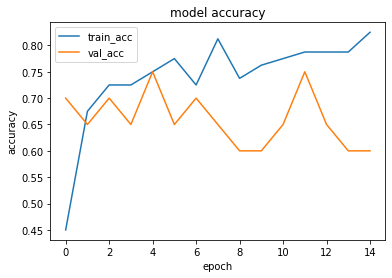

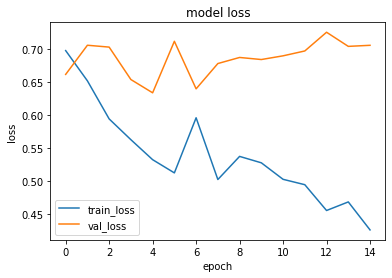

1it [00:00, 18477.11it/s]


prediction for video armflapping_1.mov is [[0.43627265]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.5422413]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_2.mov is [[0.75757873]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.30270815]]


1it [00:00, 19239.93it/s]


prediction for video control_2.mov is [[0.34005046]]


1it [00:00, 18893.26it/s]


prediction for video control_3.mov is [[0.32493252]]
Epoch 1/75
3/3 [==============================] - 0s 133ms/step - loss: 0.7140 - accuracy: 0.4500 - precision_25: 0.4717 - recall_25: 0.6098 - val_loss: 0.5972 - val_accuracy: 0.8000 - val_precision_25: 0.7778 - val_recall_25: 0.7778
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6549 - accuracy: 0.6625 - precision_25: 0.6944 - recall_25: 0.6098 - val_loss: 0.5810 - val_accuracy: 0.7000 - val_precision_25: 0.6154 - val_recall_25: 0.8889
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6156 - accuracy: 0.6625 - precision_25: 0.6296 - recall_25: 0.8293 - val_loss: 0.5310 - val_accuracy: 0.7500 - val_precision_25: 0.7000 - val_recall_25: 0.7778
Epoch 4/75
3/3 [==============================] - 0s 123ms/step - loss: 0.5814 - accuracy: 0.7750 - precision_25: 0.8108 - recall_25: 0.7317 - val_loss: 0.6114 - val_accuracy: 0.7500 - val_precision_25: 0.7000 - val_recall_25: 0.7778
Epoch 5/75


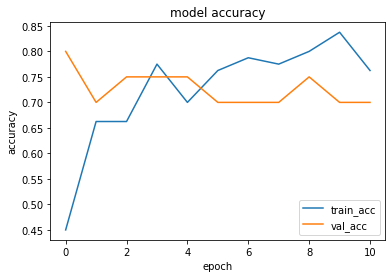

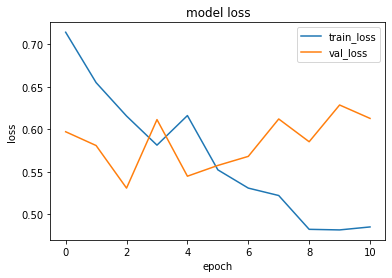

1it [00:00, 18477.11it/s]


prediction for video armflapping_1.mov is [[0.7183527]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.8555664]]


1it [00:00, 16070.13it/s]


prediction for video armflapping_2.mov is [[0.8272558]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.21552116]]


1it [00:00, 18893.26it/s]


prediction for video control_2.mov is [[0.18342167]]


1it [00:00, 17924.38it/s]

prediction for video control_3.mov is [[0.16633567]]


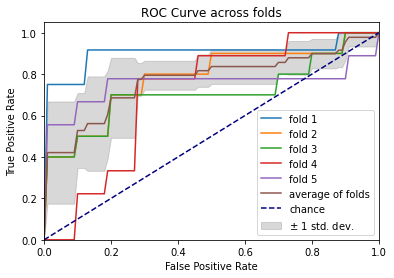

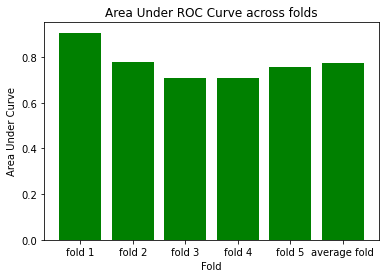

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.7375 - accuracy: 0.4875 - precision_27: 0.4211 - recall_27: 0.2105 - val_loss: 0.6491 - val_accuracy: 0.6000 - val_precision_27: 0.6000 - val_recall_27: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6979 - accuracy: 0.4875 - precision_27: 0.4805 - recall_27: 0.9737 - val_loss: 0.6255 - val_accuracy: 0.7000 - val_precision_27: 0.6875 - val_recall_27: 0.9167
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6595 - accuracy: 0.6625 - precision_27: 0.6341 - recall_27: 0.6842 - val_loss: 0.6557 - val_accuracy: 0.7500 - val_precision_27: 0.8889 - val_recall_27: 0.6667
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6619 - accuracy: 0.5750 - precision_27: 0.6250 - recall_27: 0.2632 - val_loss: 0.6345 - val_accuracy: 0.7000 - val_precision_27: 0.8750 - val_recall_27: 0.5833
Epoch 5/75
3/3 [==============================] - 0s 124ms/step 

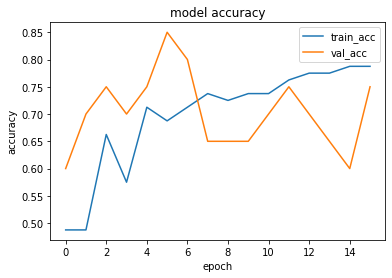

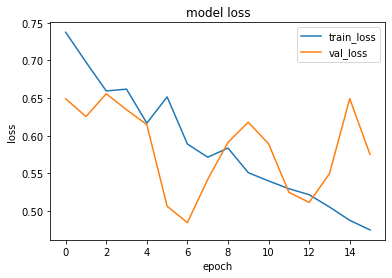

1it [00:00, 18893.26it/s]


prediction for video armflapping_1.mov is [[0.20072621]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.4028573]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.6071112]]


1it [00:00, 18477.11it/s]


prediction for video control_1.mov is [[0.1596309]]


1it [00:00, 17549.39it/s]


prediction for video control_2.mov is [[0.14933527]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.14599669]]
Epoch 1/75
3/3 [==============================] - 0s 128ms/step - loss: 0.7156 - accuracy: 0.5250 - precision_28: 0.5263 - recall_28: 0.5000 - val_loss: 0.6820 - val_accuracy: 0.6500 - val_precision_28: 0.6667 - val_recall_28: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6338 - accuracy: 0.6500 - precision_28: 0.6200 - recall_28: 0.7750 - val_loss: 0.6482 - val_accuracy: 0.5000 - val_precision_28: 0.5000 - val_recall_28: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6214 - accuracy: 0.7000 - precision_28: 0.6667 - recall_28: 0.8000 - val_loss: 0.6656 - val_accuracy: 0.7500 - val_precision_28: 0.7273 - val_recall_28: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 135ms/step - loss: 0.5746 - accuracy: 0.7750 - precision_28: 0.7895 - recall_28: 0.7500 - val_loss: 0.6804 - val_accuracy: 0.6500 - val_precision_28: 0.6667 - val_recall_28: 0.6000
Epoch 5/75


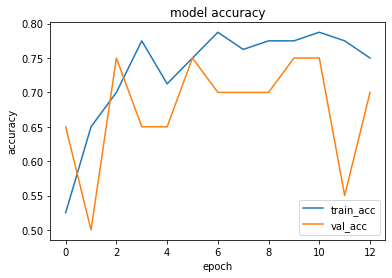

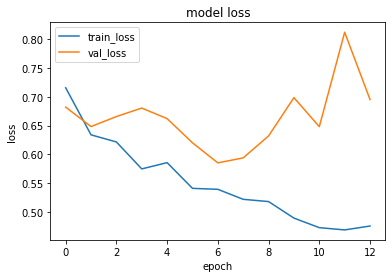

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.57151896]]


1it [00:00, 16448.25it/s]


prediction for video armflapping_3.mov is [[0.6831757]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_2.mov is [[0.7150926]]


1it [00:00, 16980.99it/s]


prediction for video control_1.mov is [[0.47528744]]


1it [00:00, 18558.87it/s]


prediction for video control_2.mov is [[0.4091323]]


1it [00:00, 18558.87it/s]


prediction for video control_3.mov is [[0.41506803]]
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6452 - accuracy: 0.6625 - precision_29: 0.6383 - recall_29: 0.7500 - val_loss: 0.6684 - val_accuracy: 0.6000 - val_precision_29: 0.5625 - val_recall_29: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.9357 - accuracy: 0.6000 - precision_29: 0.5714 - recall_29: 0.8000 - val_loss: 0.6277 - val_accuracy: 0.7500 - val_precision_29: 0.7778 - val_recall_29: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6141 - accuracy: 0.6875 - precision_29: 0.6667 - recall_29: 0.7500 - val_loss: 0.6592 - val_accuracy: 0.7000 - val_precision_29: 0.7500 - val_recall_29: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6158 - accuracy: 0.7375 - precision_29: 0.7021 - recall_29: 0.8250 - val_loss: 0.6592 - val_accuracy: 0.7000 - val_precision_29: 0.7500 - val_recall_29: 0.6000
Epoch 5/75


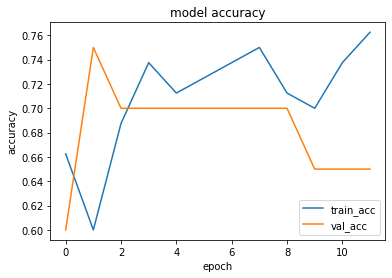

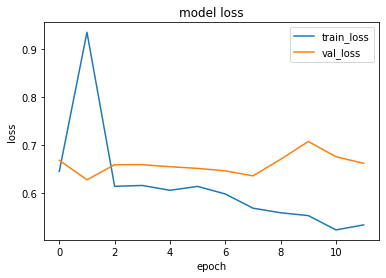

1it [00:00, 14266.34it/s]


prediction for video armflapping_1.mov is [[0.3501132]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.37771678]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_2.mov is [[0.63968486]]


1it [00:00, 18808.54it/s]


prediction for video control_1.mov is [[0.27529344]]


1it [00:00, 6853.44it/s]


prediction for video control_2.mov is [[0.24849203]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.2510251]]
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6898 - accuracy: 0.4875 - precision_30: 0.5000 - recall_30: 0.5854 - val_loss: 0.7261 - val_accuracy: 0.5000 - val_precision_30: 0.4737 - val_recall_30: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6501 - accuracy: 0.6250 - precision_30: 0.5965 - recall_30: 0.8293 - val_loss: 0.6668 - val_accuracy: 0.7000 - val_precision_30: 0.6667 - val_recall_30: 0.6667
Epoch 3/75
3/3 [==============================] - 0s 129ms/step - loss: 0.5853 - accuracy: 0.7375 - precision_30: 0.7632 - recall_30: 0.7073 - val_loss: 0.6697 - val_accuracy: 0.7000 - val_precision_30: 0.6667 - val_recall_30: 0.6667
Epoch 4/75
3/3 [==============================] - 0s 121ms/step - loss: 0.5559 - accuracy: 0.7750 - precision_30: 0.7949 - recall_30: 0.7561 - val_loss: 0.6701 - val_accuracy: 0.7000 - val_precision_30: 0.6667 - val_recall_30: 0.6667
Epoch 5/75
3

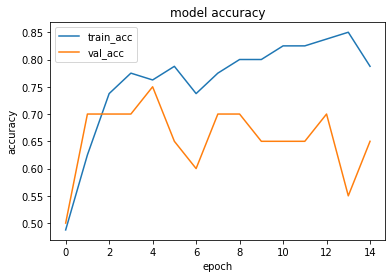

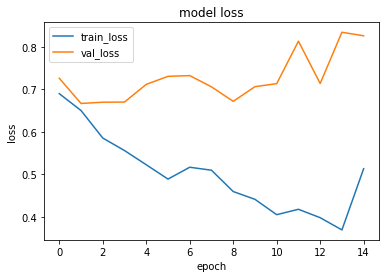

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.20368108]]


1it [00:00, 16448.25it/s]


prediction for video armflapping_3.mov is [[0.6676756]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.57032436]]


1it [00:00, 17549.39it/s]


prediction for video control_1.mov is [[0.19577107]]


1it [00:00, 19239.93it/s]


prediction for video control_2.mov is [[0.21127793]]


1it [00:00, 18808.54it/s]


prediction for video control_3.mov is [[0.21329391]]
Epoch 1/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6731 - accuracy: 0.5500 - precision_31: 0.5510 - recall_31: 0.6585 - val_loss: 0.7378 - val_accuracy: 0.5000 - val_precision_31: 0.4667 - val_recall_31: 0.7778
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6678 - accuracy: 0.6125 - precision_31: 0.6190 - recall_31: 0.6341 - val_loss: 0.5845 - val_accuracy: 0.7500 - val_precision_31: 0.7000 - val_recall_31: 0.7778
Epoch 3/75
3/3 [==============================] - 0s 121ms/step - loss: 0.5978 - accuracy: 0.7250 - precision_31: 0.7111 - recall_31: 0.7805 - val_loss: 0.5724 - val_accuracy: 0.7500 - val_precision_31: 0.7000 - val_recall_31: 0.7778
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.5813 - accuracy: 0.7000 - precision_31: 0.6809 - recall_31: 0.7805 - val_loss: 0.5616 - val_accuracy: 0.7500 - val_precision_31: 0.7000 - val_recall_31: 0.7778
Epoch 5/75


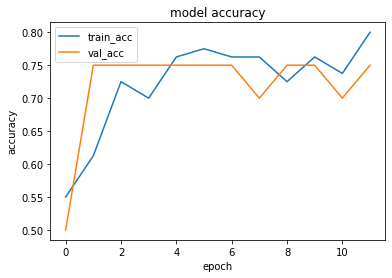

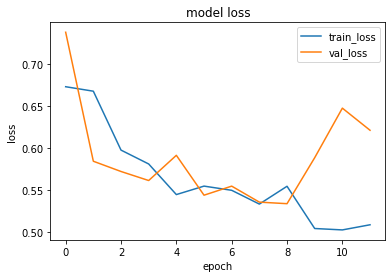

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.7778925]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.8164096]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.7796408]]


1it [00:00, 18477.11it/s]


prediction for video control_1.mov is [[0.12628663]]


1it [00:00, 19239.93it/s]


prediction for video control_2.mov is [[0.1047754]]


1it [00:00, 17189.77it/s]


prediction for video control_3.mov is [[0.0937908]]


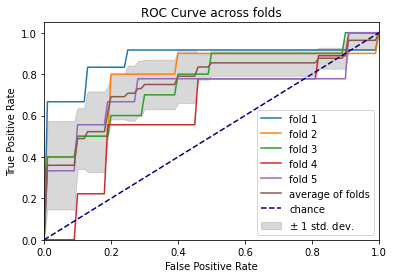

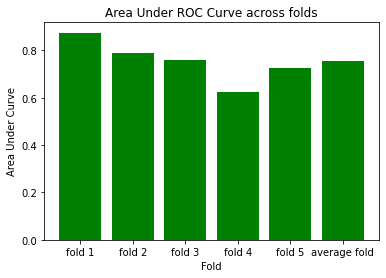

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.7081 - accuracy: 0.4500 - precision_33: 0.4211 - recall_33: 0.4211 - val_loss: 0.6255 - val_accuracy: 0.6500 - val_precision_33: 0.6316 - val_recall_33: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6605 - accuracy: 0.6625 - precision_33: 0.5965 - recall_33: 0.8947 - val_loss: 0.5953 - val_accuracy: 0.7500 - val_precision_33: 0.8889 - val_recall_33: 0.6667
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6365 - accuracy: 0.7125 - precision_33: 0.7586 - recall_33: 0.5789 - val_loss: 0.6591 - val_accuracy: 0.5500 - val_precision_33: 0.5882 - val_recall_33: 0.8333
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6511 - accuracy: 0.6750 - precision_33: 0.6200 - recall_33: 0.8158 - val_loss: 0.5476 - val_accuracy: 0.8000 - val_precision_33: 0.7857 - val_recall_33: 0.9167
Epoch 5/75
3/3 [==============================] - 0s 122ms/step 

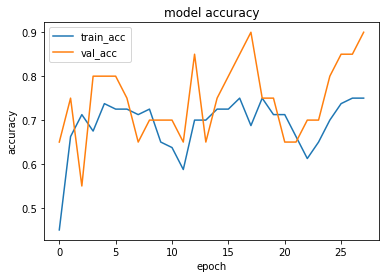

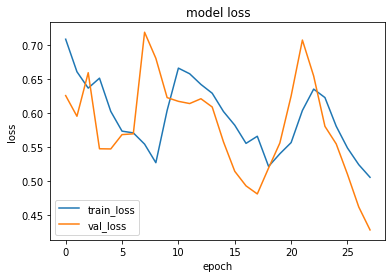

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.5741266]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.5374039]]


1it [00:00, 14122.24it/s]


prediction for video armflapping_2.mov is [[0.721071]]


1it [00:00, 17924.38it/s]


prediction for video control_1.mov is [[0.393758]]


1it [00:00, 18477.11it/s]


prediction for video control_2.mov is [[0.27408883]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.22533488]]
Epoch 1/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6931 - accuracy: 0.4250 - precision_34: 0.4531 - recall_34: 0.7250 - val_loss: 0.7225 - val_accuracy: 0.7000 - val_precision_34: 0.7500 - val_recall_34: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6138 - accuracy: 0.7375 - precision_34: 0.7021 - recall_34: 0.8250 - val_loss: 0.6558 - val_accuracy: 0.8000 - val_precision_34: 0.7500 - val_recall_34: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6095 - accuracy: 0.7125 - precision_34: 0.7073 - recall_34: 0.7250 - val_loss: 0.6135 - val_accuracy: 0.7500 - val_precision_34: 0.6923 - val_recall_34: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 130ms/step - loss: 0.5613 - accuracy: 0.7500 - precision_34: 0.7381 - recall_34: 0.7750 - val_loss: 0.5909 - val_accuracy: 0.7500 - val_precision_34: 0.7273 - val_recall_34: 0.8000
Epoch 5/75


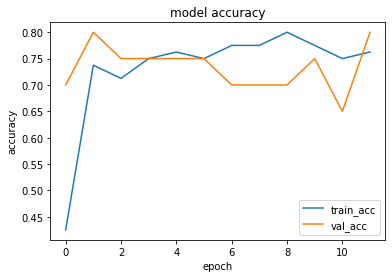

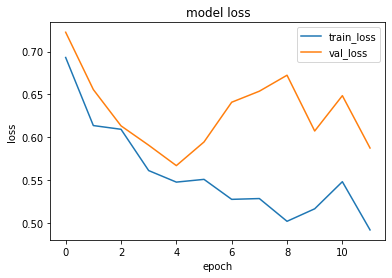

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.57457346]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.65516824]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_2.mov is [[0.6971177]]


1it [00:00, 18641.35it/s]


prediction for video control_1.mov is [[0.4562952]]


1it [00:00, 17549.39it/s]


prediction for video control_2.mov is [[0.3660324]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.36425728]]
Epoch 1/75
3/3 [==============================] - 0s 135ms/step - loss: 0.7145 - accuracy: 0.5625 - precision_35: 0.5926 - recall_35: 0.4000 - val_loss: 0.6698 - val_accuracy: 0.7000 - val_precision_35: 0.7000 - val_recall_35: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6500 - accuracy: 0.7375 - precision_35: 0.6792 - recall_35: 0.9000 - val_loss: 0.6604 - val_accuracy: 0.6500 - val_precision_35: 0.7143 - val_recall_35: 0.5000
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.5879 - accuracy: 0.7250 - precision_35: 0.7368 - recall_35: 0.7000 - val_loss: 0.6122 - val_accuracy: 0.6000 - val_precision_35: 0.6000 - val_recall_35: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.5821 - accuracy: 0.7375 - precision_35: 0.7317 - recall_35: 0.7500 - val_loss: 0.6384 - val_accuracy: 0.7000 - val_precision_35: 0.8333 - val_recall_35: 0.5000
Epoch 5/75


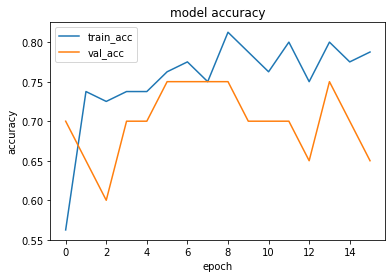

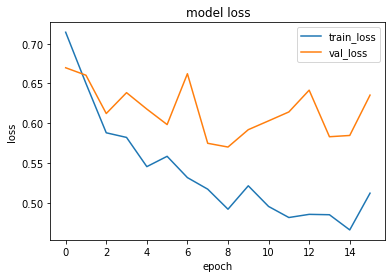

1it [00:00, 18558.87it/s]


prediction for video armflapping_1.mov is [[0.35303384]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_3.mov is [[0.5381469]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.67225]]


1it [00:00, 17924.38it/s]


prediction for video control_1.mov is [[0.31895953]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.3285055]]


1it [00:00, 18558.87it/s]


prediction for video control_3.mov is [[0.32039028]]
Epoch 1/75
3/3 [==============================] - 0s 132ms/step - loss: 0.7000 - accuracy: 0.4625 - precision_36: 0.4821 - recall_36: 0.6585 - val_loss: 0.6578 - val_accuracy: 0.6000 - val_precision_36: 0.6000 - val_recall_36: 0.3333
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6256 - accuracy: 0.7250 - precision_36: 0.8519 - recall_36: 0.5610 - val_loss: 0.7690 - val_accuracy: 0.5500 - val_precision_36: 0.5000 - val_recall_36: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6314 - accuracy: 0.6625 - precision_36: 0.6250 - recall_36: 0.8537 - val_loss: 0.6474 - val_accuracy: 0.6500 - val_precision_36: 0.6250 - val_recall_36: 0.5556
Epoch 4/75
3/3 [==============================] - 0s 121ms/step - loss: 0.5488 - accuracy: 0.7750 - precision_36: 0.7949 - recall_36: 0.7561 - val_loss: 0.6362 - val_accuracy: 0.6500 - val_precision_36: 0.6250 - val_recall_36: 0.5556
Epoch 5/75


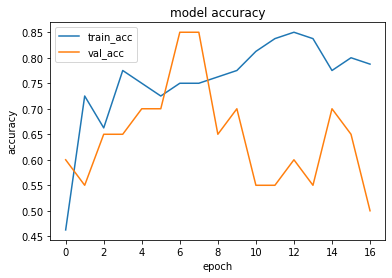

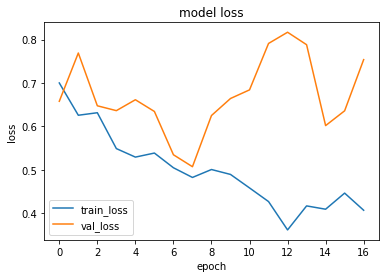

1it [00:00, 18893.26it/s]


prediction for video armflapping_1.mov is [[0.50518435]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.84065175]]


1it [00:00, 16448.25it/s]


prediction for video armflapping_2.mov is [[0.6957287]]


1it [00:00, 18893.26it/s]


prediction for video control_1.mov is [[0.288826]]


1it [00:00, 18893.26it/s]


prediction for video control_2.mov is [[0.29481483]]


1it [00:00, 18558.87it/s]


prediction for video control_3.mov is [[0.27206746]]
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6905 - accuracy: 0.4875 - precision_37: 0.5000 - recall_37: 0.7073 - val_loss: 0.8033 - val_accuracy: 0.4500 - val_precision_37: 0.4500 - val_recall_37: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6834 - accuracy: 0.5875 - precision_37: 0.5645 - recall_37: 0.8537 - val_loss: 0.6672 - val_accuracy: 0.6500 - val_precision_37: 0.6000 - val_recall_37: 0.6667
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6646 - accuracy: 0.6375 - precision_37: 0.7000 - recall_37: 0.5122 - val_loss: 0.6049 - val_accuracy: 0.7000 - val_precision_37: 0.8000 - val_recall_37: 0.4444
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6678 - accuracy: 0.6000 - precision_37: 0.7647 - recall_37: 0.3171 - val_loss: 0.5846 - val_accuracy: 0.7000 - val_precision_37: 0.6667 - val_recall_37: 0.6667
Epoch 5/75


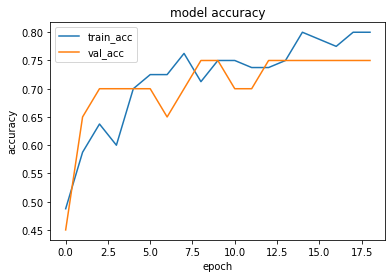

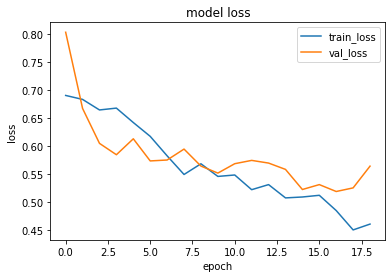

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.12503514]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.7918041]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_2.mov is [[0.8077369]]


1it [00:00, 17772.47it/s]


prediction for video control_1.mov is [[0.09708628]]


1it [00:00, 14716.86it/s]


prediction for video control_2.mov is [[0.09069657]]


1it [00:00, 19599.55it/s]


prediction for video control_3.mov is [[0.09032291]]


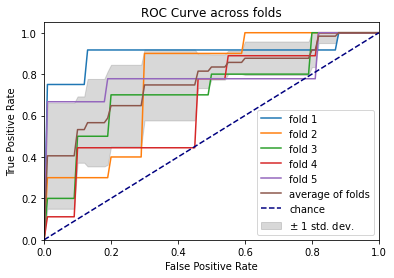

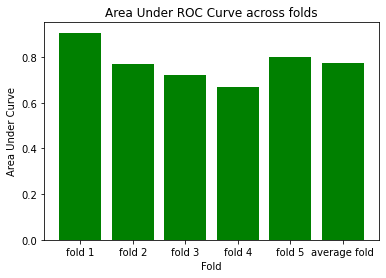

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6709 - accuracy: 0.6750 - precision_39: 0.6500 - recall_39: 0.6842 - val_loss: 1.1151 - val_accuracy: 0.4000 - val_precision_39: 0.0000e+00 - val_recall_39: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 122ms/step - loss: 0.7535 - accuracy: 0.6000 - precision_39: 1.0000 - recall_39: 0.1579 - val_loss: 0.6063 - val_accuracy: 0.7500 - val_precision_39: 1.0000 - val_recall_39: 0.5833
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6657 - accuracy: 0.6750 - precision_39: 0.6765 - recall_39: 0.6053 - val_loss: 0.5803 - val_accuracy: 0.7000 - val_precision_39: 0.6875 - val_recall_39: 0.9167
Epoch 4/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6341 - accuracy: 0.7125 - precision_39: 0.6829 - recall_39: 0.7368 - val_loss: 0.5685 - val_accuracy: 0.6500 - val_precision_39: 0.6471 - val_recall_39: 0.9167
Epoch 5/75
3/3 [==============================] - 0s 121

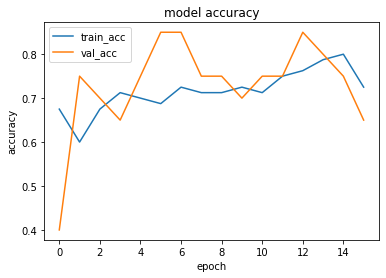

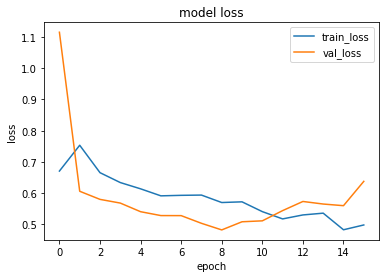

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.26576996]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.37092686]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.44840688]]


1it [00:00, 18477.11it/s]


prediction for video control_1.mov is [[0.21602246]]


1it [00:00, 19239.93it/s]


prediction for video control_2.mov is [[0.20327452]]


1it [00:00, 17476.27it/s]


prediction for video control_3.mov is [[0.19793436]]
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6882 - accuracy: 0.5875 - precision_40: 0.5814 - recall_40: 0.6250 - val_loss: 0.6972 - val_accuracy: 0.7000 - val_precision_40: 0.7500 - val_recall_40: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 186ms/step - loss: 0.6422 - accuracy: 0.7000 - precision_40: 0.7500 - recall_40: 0.6000 - val_loss: 0.6877 - val_accuracy: 0.7000 - val_precision_40: 0.7000 - val_recall_40: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6242 - accuracy: 0.7000 - precision_40: 0.6667 - recall_40: 0.8000 - val_loss: 0.6107 - val_accuracy: 0.7500 - val_precision_40: 0.6923 - val_recall_40: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6005 - accuracy: 0.6875 - precision_40: 0.6471 - recall_40: 0.8250 - val_loss: 0.5821 - val_accuracy: 0.8000 - val_precision_40: 0.7500 - val_recall_40: 0.9000
Epoch 5/75


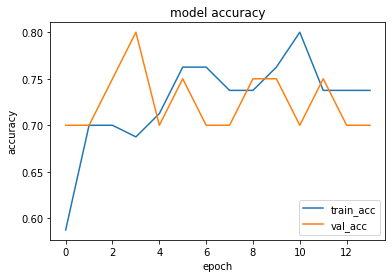

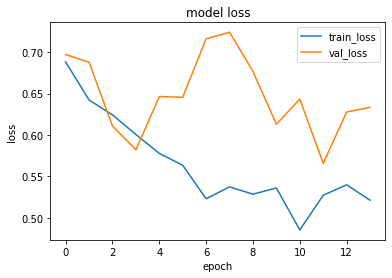

1it [00:00, 13706.88it/s]


prediction for video armflapping_1.mov is [[0.551775]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.5836465]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_2.mov is [[0.67991686]]


1it [00:00, 17623.13it/s]


prediction for video control_1.mov is [[0.43274945]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.36261868]]


1it [00:00, 16644.06it/s]


prediction for video control_3.mov is [[0.3535841]]
Epoch 1/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6743 - accuracy: 0.5375 - precision_41: 0.5429 - recall_41: 0.4750 - val_loss: 0.6443 - val_accuracy: 0.6500 - val_precision_41: 0.6364 - val_recall_41: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6450 - accuracy: 0.6875 - precision_41: 0.6829 - recall_41: 0.7000 - val_loss: 0.6400 - val_accuracy: 0.7000 - val_precision_41: 0.7500 - val_recall_41: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6032 - accuracy: 0.7500 - precision_41: 0.7000 - recall_41: 0.8750 - val_loss: 0.6069 - val_accuracy: 0.7000 - val_precision_41: 0.6667 - val_recall_41: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 130ms/step - loss: 0.5925 - accuracy: 0.6750 - precision_41: 0.6296 - recall_41: 0.8500 - val_loss: 0.5882 - val_accuracy: 0.6500 - val_precision_41: 0.6667 - val_recall_41: 0.6000
Epoch 5/75
3

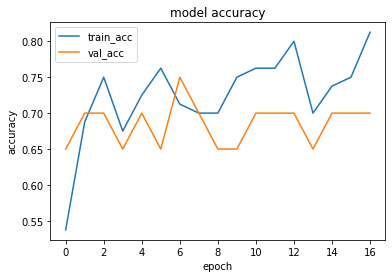

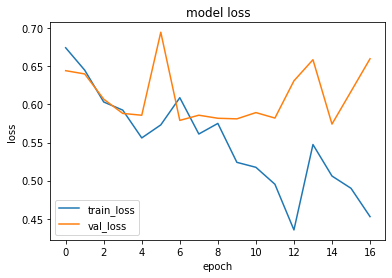

1it [00:00, 18558.87it/s]


prediction for video armflapping_1.mov is [[0.21346205]]


1it [00:00, 17772.47it/s]


prediction for video armflapping_3.mov is [[0.36518753]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.33660907]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.29489776]]


1it [00:00, 19599.55it/s]


prediction for video control_2.mov is [[0.16556168]]


1it [00:00, 18558.87it/s]


prediction for video control_3.mov is [[0.22924754]]
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.7070 - accuracy: 0.5750 - precision_42: 0.5556 - recall_42: 0.8537 - val_loss: 0.6623 - val_accuracy: 0.6500 - val_precision_42: 0.6250 - val_recall_42: 0.5556
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6532 - accuracy: 0.5375 - precision_42: 0.5370 - recall_42: 0.7073 - val_loss: 0.6841 - val_accuracy: 0.6500 - val_precision_42: 0.5714 - val_recall_42: 0.8889
Epoch 3/75
3/3 [==============================] - 0s 129ms/step - loss: 0.5963 - accuracy: 0.7500 - precision_42: 0.7333 - recall_42: 0.8049 - val_loss: 0.6515 - val_accuracy: 0.7000 - val_precision_42: 0.6667 - val_recall_42: 0.6667
Epoch 4/75
3/3 [==============================] - 0s 125ms/step - loss: 0.5670 - accuracy: 0.7875 - precision_42: 0.8000 - recall_42: 0.7805 - val_loss: 0.6296 - val_accuracy: 0.6500 - val_precision_42: 0.5833 - val_recall_42: 0.7778
Epoch 5/75


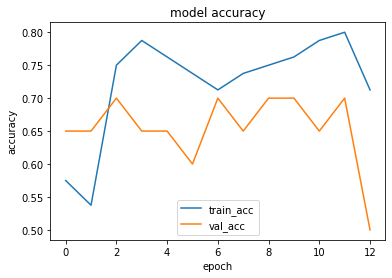

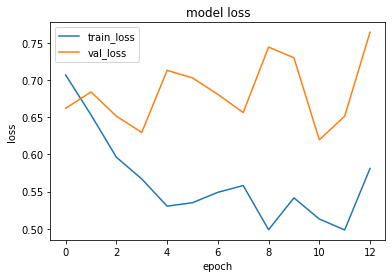

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.23111078]]


1it [00:00, 19599.55it/s]


prediction for video armflapping_3.mov is [[0.81328374]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_2.mov is [[0.7718721]]


1it [00:00, 18236.10it/s]


prediction for video control_1.mov is [[0.17605057]]


1it [00:00, 18893.26it/s]


prediction for video control_2.mov is [[0.17291942]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.15620369]]
Epoch 1/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6603 - accuracy: 0.5875 - precision_43: 0.5556 - recall_43: 0.9756 - val_loss: 0.6350 - val_accuracy: 0.5500 - val_precision_43: 0.0000e+00 - val_recall_43: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 185ms/step - loss: 0.6506 - accuracy: 0.6625 - precision_43: 0.7500 - recall_43: 0.5122 - val_loss: 0.9278 - val_accuracy: 0.5000 - val_precision_43: 0.4667 - val_recall_43: 0.7778
Epoch 3/75
3/3 [==============================] - 0s 128ms/step - loss: 0.7152 - accuracy: 0.6750 - precision_43: 0.6415 - recall_43: 0.8293 - val_loss: 0.6703 - val_accuracy: 0.5500 - val_precision_43: 0.5000 - val_recall_43: 0.6667
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6154 - accuracy: 0.6750 - precision_43: 0.6923 - recall_43: 0.6585 - val_loss: 0.6221 - val_accuracy: 0.7500 - val_precision_43: 0.7000 - val_recall_43: 0.7778
Epo

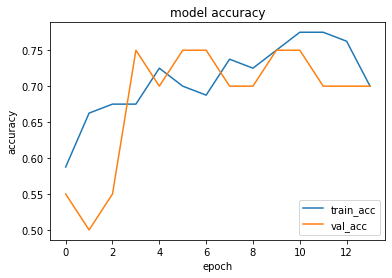

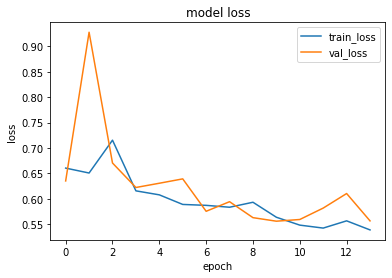

1it [00:00, 18558.87it/s]


prediction for video armflapping_1.mov is [[0.31873688]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_3.mov is [[0.39372057]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_2.mov is [[0.70550424]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.18595871]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.171675]]


1it [00:00, 18893.26it/s]


prediction for video control_3.mov is [[0.1671294]]


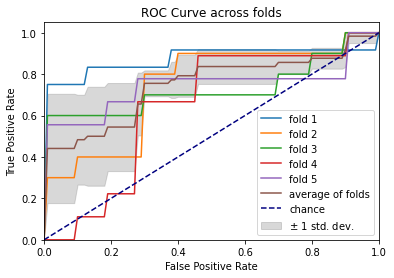

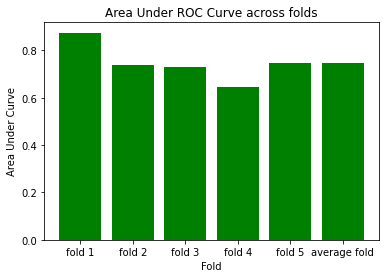

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.7212 - accuracy: 0.4375 - precision_45: 0.3600 - recall_45: 0.2368 - val_loss: 0.6484 - val_accuracy: 0.7500 - val_precision_45: 0.7333 - val_recall_45: 0.9167
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6781 - accuracy: 0.6125 - precision_45: 0.5593 - recall_45: 0.8684 - val_loss: 0.5846 - val_accuracy: 0.6500 - val_precision_45: 0.6471 - val_recall_45: 0.9167
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6431 - accuracy: 0.7250 - precision_45: 0.7000 - recall_45: 0.7368 - val_loss: 0.6104 - val_accuracy: 0.7500 - val_precision_45: 1.0000 - val_recall_45: 0.5833
Epoch 4/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6322 - accuracy: 0.6750 - precision_45: 0.7727 - recall_45: 0.4474 - val_loss: 0.7336 - val_accuracy: 0.6500 - val_precision_45: 0.8571 - val_recall_45: 0.5000
Epoch 5/75
3/3 [==============================] - 0s 123ms/step 

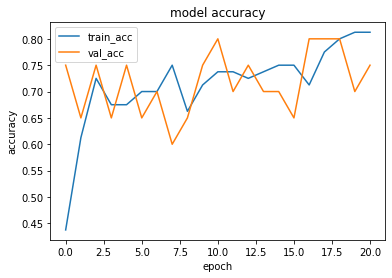

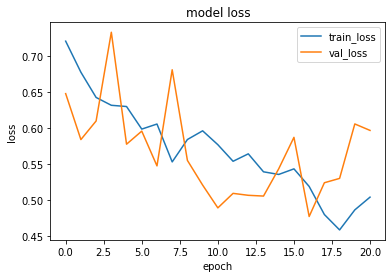

1it [00:00, 18236.10it/s]


prediction for video armflapping_1.mov is [[0.5948705]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_3.mov is [[0.6435737]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_2.mov is [[0.66364557]]


1it [00:00, 17549.39it/s]


prediction for video control_1.mov is [[0.43272513]]


1it [00:00, 19239.93it/s]


prediction for video control_2.mov is [[0.3081618]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.20488429]]
Epoch 1/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6602 - accuracy: 0.6000 - precision_46: 0.6111 - recall_46: 0.5500 - val_loss: 0.7424 - val_accuracy: 0.5500 - val_precision_46: 0.5294 - val_recall_46: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6285 - accuracy: 0.6875 - precision_46: 0.6471 - recall_46: 0.8250 - val_loss: 0.7195 - val_accuracy: 0.7000 - val_precision_46: 0.7500 - val_recall_46: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6234 - accuracy: 0.6625 - precision_46: 0.7600 - recall_46: 0.4750 - val_loss: 0.6648 - val_accuracy: 0.7500 - val_precision_46: 0.7273 - val_recall_46: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 136ms/step - loss: 0.5559 - accuracy: 0.7750 - precision_46: 0.8056 - recall_46: 0.7250 - val_loss: 0.6490 - val_accuracy: 0.7500 - val_precision_46: 0.7273 - val_recall_46: 0.8000
Epoch 5/75


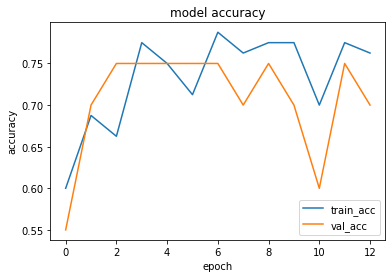

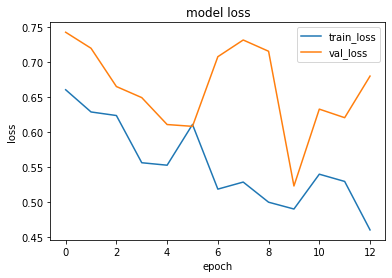

1it [00:00, 17189.77it/s]


prediction for video armflapping_1.mov is [[0.64076537]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_3.mov is [[0.7473897]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_2.mov is [[0.756683]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.47663662]]


1it [00:00, 19691.57it/s]


prediction for video control_2.mov is [[0.40639728]]


1it [00:00, 17924.38it/s]


prediction for video control_3.mov is [[0.36227667]]
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6679 - accuracy: 0.5375 - precision_47: 0.5429 - recall_47: 0.4750 - val_loss: 0.6236 - val_accuracy: 0.7500 - val_precision_47: 0.7778 - val_recall_47: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6364 - accuracy: 0.6875 - precision_47: 0.7027 - recall_47: 0.6500 - val_loss: 0.6017 - val_accuracy: 0.7000 - val_precision_47: 0.7500 - val_recall_47: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.5683 - accuracy: 0.7375 - precision_47: 0.7111 - recall_47: 0.8000 - val_loss: 0.6714 - val_accuracy: 0.6500 - val_precision_47: 0.8000 - val_recall_47: 0.4000
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6017 - accuracy: 0.6375 - precision_47: 0.6667 - recall_47: 0.5500 - val_loss: 0.6862 - val_accuracy: 0.7000 - val_precision_47: 1.0000 - val_recall_47: 0.4000
Epoch 5/75


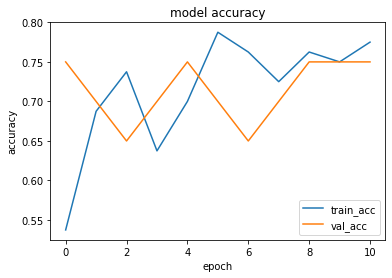

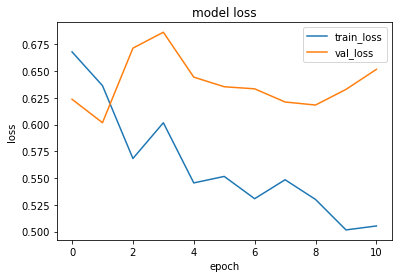

1it [00:00, 18558.87it/s]


prediction for video armflapping_1.mov is [[0.43446106]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.555211]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.6696052]]


1it [00:00, 18315.74it/s]


prediction for video control_1.mov is [[0.20791343]]


1it [00:00, 18893.26it/s]


prediction for video control_2.mov is [[0.15371078]]


1it [00:00, 18893.26it/s]


prediction for video control_3.mov is [[0.14404511]]
Epoch 1/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6955 - accuracy: 0.5875 - precision_48: 0.5625 - recall_48: 0.8780 - val_loss: 0.6591 - val_accuracy: 0.7500 - val_precision_48: 0.7000 - val_recall_48: 0.7778
Epoch 2/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6374 - accuracy: 0.6625 - precision_48: 0.6400 - recall_48: 0.7805 - val_loss: 0.6729 - val_accuracy: 0.6500 - val_precision_48: 0.5714 - val_recall_48: 0.8889
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6113 - accuracy: 0.6750 - precision_48: 0.6415 - recall_48: 0.8293 - val_loss: 0.6683 - val_accuracy: 0.7000 - val_precision_48: 0.6364 - val_recall_48: 0.7778
Epoch 4/75
3/3 [==============================] - 0s 129ms/step - loss: 0.5739 - accuracy: 0.7250 - precision_48: 0.7317 - recall_48: 0.7317 - val_loss: 0.6456 - val_accuracy: 0.6500 - val_precision_48: 0.6250 - val_recall_48: 0.5556
Epoch 5/75


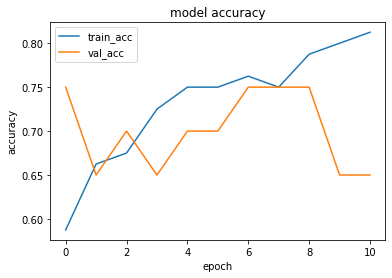

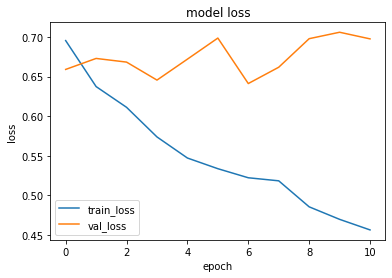

1it [00:00, 18236.10it/s]


prediction for video armflapping_1.mov is [[0.5273566]]


1it [00:00, 18808.54it/s]


prediction for video armflapping_3.mov is [[0.8133658]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_2.mov is [[0.7297104]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.3618073]]


1it [00:00, 18893.26it/s]


prediction for video control_2.mov is [[0.3167845]]


1it [00:00, 18236.10it/s]


prediction for video control_3.mov is [[0.280667]]
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.7020 - accuracy: 0.6125 - precision_49: 0.5781 - recall_49: 0.9024 - val_loss: 0.6070 - val_accuracy: 0.7000 - val_precision_49: 0.6667 - val_recall_49: 0.6667
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6530 - accuracy: 0.7250 - precision_49: 0.8065 - recall_49: 0.6098 - val_loss: 0.6205 - val_accuracy: 0.7000 - val_precision_49: 0.6364 - val_recall_49: 0.7778
Epoch 3/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6531 - accuracy: 0.6875 - precision_49: 0.6538 - recall_49: 0.8293 - val_loss: 0.6595 - val_accuracy: 0.6500 - val_precision_49: 0.5833 - val_recall_49: 0.7778
Epoch 4/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6229 - accuracy: 0.6875 - precision_49: 0.6429 - recall_49: 0.8780 - val_loss: 0.5823 - val_accuracy: 0.7000 - val_precision_49: 0.6364 - val_recall_49: 0.7778
Epoch 5/75
3/

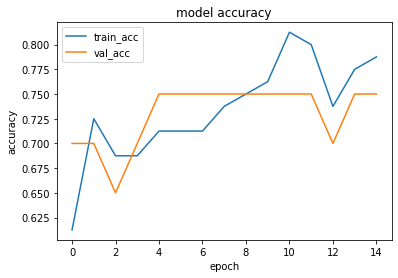

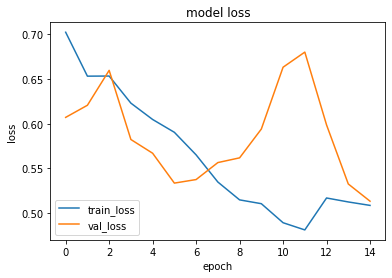

1it [00:00, 19239.93it/s]


prediction for video armflapping_1.mov is [[0.60712194]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.70594245]]


1it [00:00, 17260.51it/s]


prediction for video armflapping_2.mov is [[0.67406315]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.16827756]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.16089058]]


1it [00:00, 18157.16it/s]

prediction for video control_3.mov is [[0.1596736]]


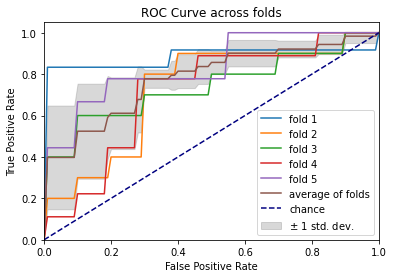

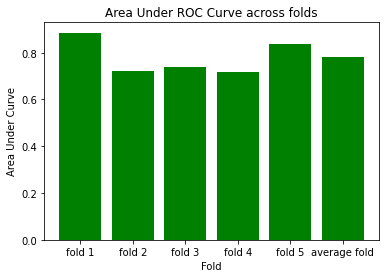

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6980 - accuracy: 0.3875 - precision_51: 0.3226 - recall_51: 0.2632 - val_loss: 0.6218 - val_accuracy: 0.6500 - val_precision_51: 0.6471 - val_recall_51: 0.9167
Epoch 2/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6609 - accuracy: 0.6625 - precision_51: 0.6000 - recall_51: 0.8684 - val_loss: 0.5702 - val_accuracy: 0.7500 - val_precision_51: 0.7692 - val_recall_51: 0.8333
Epoch 3/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6399 - accuracy: 0.7000 - precision_51: 0.7059 - recall_51: 0.6316 - val_loss: 0.5713 - val_accuracy: 0.8000 - val_precision_51: 0.8333 - val_recall_51: 0.8333
Epoch 4/75
3/3 [==============================] - 0s 121ms/step - loss: 0.5958 - accuracy: 0.7125 - precision_51: 0.7027 - recall_51: 0.6842 - val_loss: 0.5398 - val_accuracy: 0.6500 - val_precision_51: 0.6667 - val_recall_51: 0.8333
Epoch 5/75
3/3 [==============================] - 0s 130ms/step 

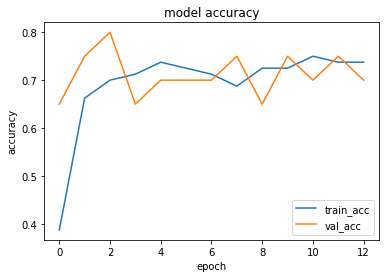

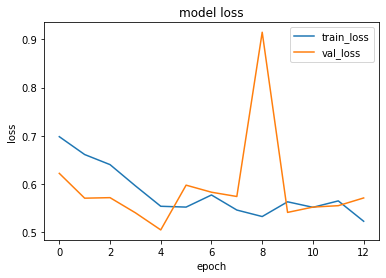

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.5037197]]


1it [00:00, 19152.07it/s]


prediction for video armflapping_3.mov is [[0.53118056]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_2.mov is [[0.5377303]]


1it [00:00, 18315.74it/s]


prediction for video control_1.mov is [[0.4572791]]


1it [00:00, 17623.13it/s]


prediction for video control_2.mov is [[0.435761]]


1it [00:00, 15592.21it/s]


prediction for video control_3.mov is [[0.422004]]
Epoch 1/75
3/3 [==============================] - 0s 134ms/step - loss: 0.7270 - accuracy: 0.4125 - precision_52: 0.4000 - recall_52: 0.3500 - val_loss: 0.6754 - val_accuracy: 0.4500 - val_precision_52: 0.4706 - val_recall_52: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6372 - accuracy: 0.6250 - precision_52: 0.5758 - recall_52: 0.9500 - val_loss: 0.6441 - val_accuracy: 0.7000 - val_precision_52: 0.6667 - val_recall_52: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 127ms/step - loss: 0.5891 - accuracy: 0.7500 - precision_52: 0.7632 - recall_52: 0.7250 - val_loss: 0.6246 - val_accuracy: 0.7500 - val_precision_52: 0.7273 - val_recall_52: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 129ms/step - loss: 0.5665 - accuracy: 0.7625 - precision_52: 0.7692 - recall_52: 0.7500 - val_loss: 0.5756 - val_accuracy: 0.7500 - val_precision_52: 0.7273 - val_recall_52: 0.8000
Epoch 5/75
3/

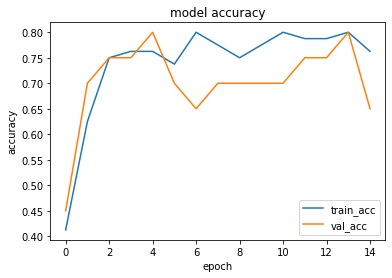

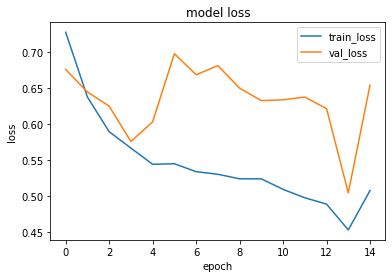

1it [00:00, 15592.21it/s]


prediction for video armflapping_1.mov is [[0.6060372]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.6854606]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_2.mov is [[0.6993555]]


1it [00:00, 18477.11it/s]


prediction for video control_1.mov is [[0.48271427]]


1it [00:00, 16912.52it/s]


prediction for video control_2.mov is [[0.38705778]]


1it [00:00, 19152.07it/s]


prediction for video control_3.mov is [[0.3628055]]
Epoch 1/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6424 - accuracy: 0.6750 - precision_53: 0.6458 - recall_53: 0.7750 - val_loss: 0.6527 - val_accuracy: 0.6500 - val_precision_53: 0.6000 - val_recall_53: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6686 - accuracy: 0.6375 - precision_53: 0.5965 - recall_53: 0.8500 - val_loss: 0.6756 - val_accuracy: 0.7000 - val_precision_53: 1.0000 - val_recall_53: 0.4000
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.5889 - accuracy: 0.7125 - precision_53: 0.7931 - recall_53: 0.5750 - val_loss: 0.6290 - val_accuracy: 0.7000 - val_precision_53: 0.8333 - val_recall_53: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.5479 - accuracy: 0.7625 - precision_53: 0.7692 - recall_53: 0.7500 - val_loss: 0.5910 - val_accuracy: 0.7000 - val_precision_53: 0.7000 - val_recall_53: 0.7000
Epoch 5/75
3

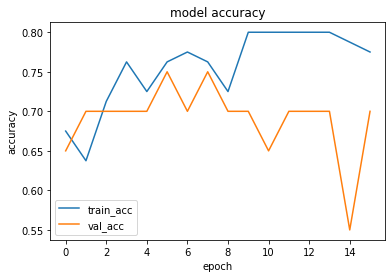

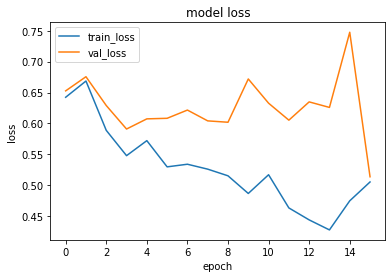

1it [00:00, 16320.25it/s]


prediction for video armflapping_1.mov is [[0.2755983]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.8233665]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_2.mov is [[0.7475028]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.19806847]]


1it [00:00, 18477.11it/s]


prediction for video control_2.mov is [[0.15845153]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.1897217]]
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6746 - accuracy: 0.6375 - precision_54: 0.6429 - recall_54: 0.6585 - val_loss: 0.6998 - val_accuracy: 0.6000 - val_precision_54: 0.5385 - val_recall_54: 0.7778
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6191 - accuracy: 0.6875 - precision_54: 0.6905 - recall_54: 0.7073 - val_loss: 0.6823 - val_accuracy: 0.6500 - val_precision_54: 0.5833 - val_recall_54: 0.7778
Epoch 3/75
3/3 [==============================] - 0s 127ms/step - loss: 0.5863 - accuracy: 0.7000 - precision_54: 0.6735 - recall_54: 0.8049 - val_loss: 0.6685 - val_accuracy: 0.6500 - val_precision_54: 0.6000 - val_recall_54: 0.6667
Epoch 4/75
3/3 [==============================] - 0s 129ms/step - loss: 0.5398 - accuracy: 0.7500 - precision_54: 0.7442 - recall_54: 0.7805 - val_loss: 0.6498 - val_accuracy: 0.6500 - val_precision_54: 0.6250 - val_recall_54: 0.5556
Epoch 5/75
3

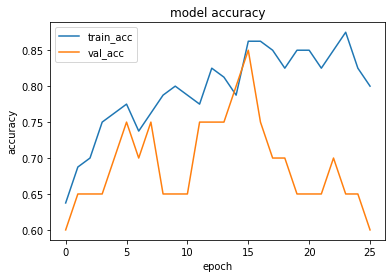

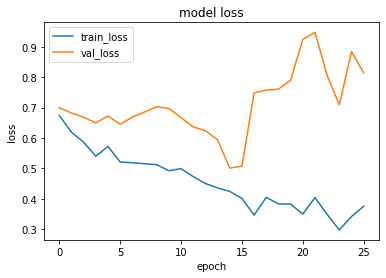

1it [00:00, 14873.42it/s]


prediction for video armflapping_1.mov is [[0.5332205]]


1it [00:00, 18641.35it/s]


prediction for video armflapping_3.mov is [[0.80795336]]


1it [00:00, 17260.51it/s]


prediction for video armflapping_2.mov is [[0.75734854]]


1it [00:00, 20460.02it/s]


prediction for video control_1.mov is [[0.23606092]]


1it [00:00, 17189.77it/s]


prediction for video control_2.mov is [[0.22467905]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.2219238]]
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6838 - accuracy: 0.5750 - precision_55: 0.6522 - recall_55: 0.3659 - val_loss: 0.7567 - val_accuracy: 0.4500 - val_precision_55: 0.4500 - val_recall_55: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6711 - accuracy: 0.6500 - precision_55: 0.6032 - recall_55: 0.9268 - val_loss: 0.5834 - val_accuracy: 0.7500 - val_precision_55: 0.7000 - val_recall_55: 0.7778
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6226 - accuracy: 0.7250 - precision_55: 0.7714 - recall_55: 0.6585 - val_loss: 0.5660 - val_accuracy: 0.7000 - val_precision_55: 0.6667 - val_recall_55: 0.6667
Epoch 4/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6582 - accuracy: 0.6625 - precision_55: 0.8182 - recall_55: 0.4390 - val_loss: 0.6483 - val_accuracy: 0.7000 - val_precision_55: 0.6667 - val_recall_55: 0.6667
Epoch 5/75
3

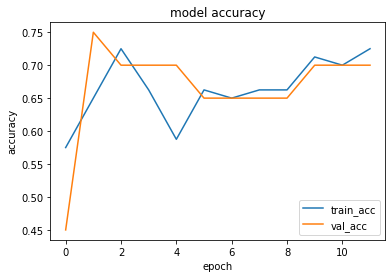

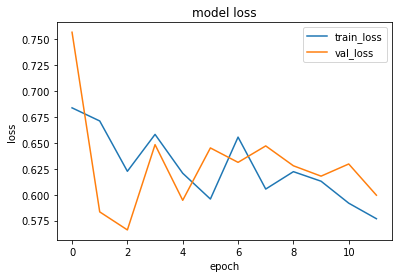

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.5854882]]


1it [00:00, 18641.35it/s]


prediction for video armflapping_3.mov is [[0.5419986]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.6871612]]


1it [00:00, 17623.13it/s]


prediction for video control_1.mov is [[0.3401056]]


1it [00:00, 19599.55it/s]


prediction for video control_2.mov is [[0.24719828]]


1it [00:00, 18893.26it/s]


prediction for video control_3.mov is [[0.21032146]]


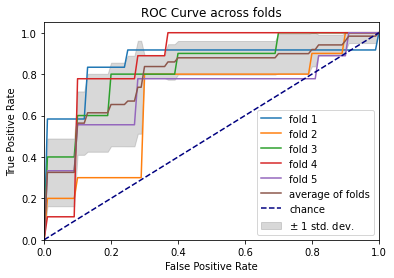

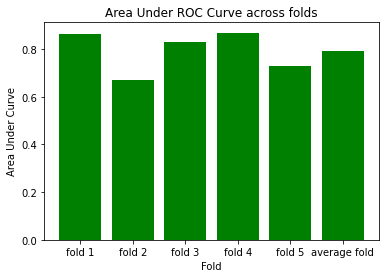

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 0s 132ms/step - loss: 0.7115 - accuracy: 0.5250 - precision_57: 0.5000 - recall_57: 0.3947 - val_loss: 0.6367 - val_accuracy: 0.6000 - val_precision_57: 0.6000 - val_recall_57: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 188ms/step - loss: 0.7082 - accuracy: 0.5000 - precision_57: 0.4861 - recall_57: 0.9211 - val_loss: 0.6167 - val_accuracy: 0.7000 - val_precision_57: 0.6875 - val_recall_57: 0.9167
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6459 - accuracy: 0.6875 - precision_57: 0.6757 - recall_57: 0.6579 - val_loss: 0.6491 - val_accuracy: 0.6500 - val_precision_57: 1.0000 - val_recall_57: 0.4167
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6453 - accuracy: 0.6250 - precision_57: 0.7000 - recall_57: 0.3684 - val_loss: 0.6207 - val_accuracy: 0.7000 - val_precision_57: 1.0000 - val_recall_57: 0.5000
Epoch 5/75
3/3 [==============================] - 0s 122ms/step 

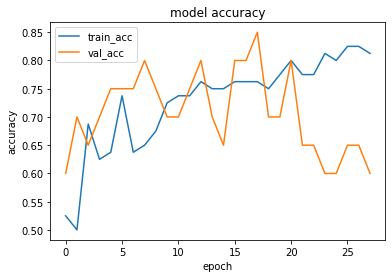

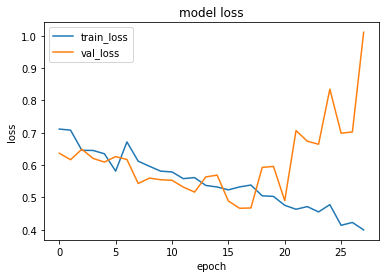

1it [00:00, 18315.74it/s]


prediction for video armflapping_1.mov is [[0.3364144]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.49374685]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_2.mov is [[0.6603916]]


1it [00:00, 17189.77it/s]


prediction for video control_1.mov is [[0.29448837]]


1it [00:00, 18477.11it/s]


prediction for video control_2.mov is [[0.24605891]]


1it [00:00, 16710.37it/s]


prediction for video control_3.mov is [[0.22523049]]
Epoch 1/75
3/3 [==============================] - 0s 183ms/step - loss: 0.6846 - accuracy: 0.5500 - precision_58: 0.5345 - recall_58: 0.7750 - val_loss: 0.7088 - val_accuracy: 0.7000 - val_precision_58: 0.8333 - val_recall_58: 0.5000
Epoch 2/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6565 - accuracy: 0.6500 - precision_58: 0.7143 - recall_58: 0.5000 - val_loss: 0.6556 - val_accuracy: 0.5000 - val_precision_58: 0.5000 - val_recall_58: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6067 - accuracy: 0.6125 - precision_58: 0.5738 - recall_58: 0.8750 - val_loss: 0.6508 - val_accuracy: 0.7500 - val_precision_58: 0.6923 - val_recall_58: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 134ms/step - loss: 0.5730 - accuracy: 0.7250 - precision_58: 0.7250 - recall_58: 0.7250 - val_loss: 0.5974 - val_accuracy: 0.7000 - val_precision_58: 0.6667 - val_recall_58: 0.8000
Epoch 5/75


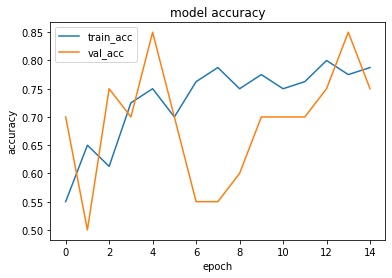

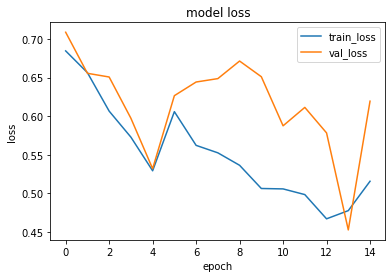

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.505908]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_3.mov is [[0.5289259]]


1it [00:00, 17189.77it/s]


prediction for video armflapping_2.mov is [[0.55547065]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.3843594]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.35532615]]


1it [00:00, 15650.39it/s]


prediction for video control_3.mov is [[0.3317154]]
Epoch 1/75
3/3 [==============================] - 0s 133ms/step - loss: 0.7098 - accuracy: 0.4250 - precision_59: 0.3750 - recall_59: 0.2250 - val_loss: 0.6612 - val_accuracy: 0.5000 - val_precision_59: 0.5000 - val_recall_59: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6428 - accuracy: 0.6250 - precision_59: 0.5833 - recall_59: 0.8750 - val_loss: 0.6727 - val_accuracy: 0.7000 - val_precision_59: 1.0000 - val_recall_59: 0.4000
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6270 - accuracy: 0.7250 - precision_59: 0.7647 - recall_59: 0.6500 - val_loss: 0.6507 - val_accuracy: 0.7000 - val_precision_59: 0.7500 - val_recall_59: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.5872 - accuracy: 0.7250 - precision_59: 0.7143 - recall_59: 0.7500 - val_loss: 0.6432 - val_accuracy: 0.7000 - val_precision_59: 0.7500 - val_recall_59: 0.6000
Epoch 5/75
3

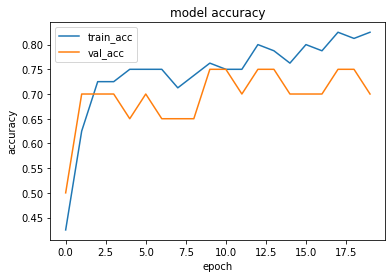

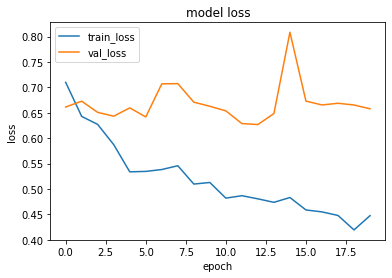

1it [00:00, 18477.11it/s]


prediction for video armflapping_1.mov is [[0.37177116]]


1it [00:00, 19599.55it/s]


prediction for video armflapping_3.mov is [[0.0848414]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.5303375]]


1it [00:00, 18477.11it/s]


prediction for video control_1.mov is [[0.31799886]]


1it [00:00, 15592.21it/s]


prediction for video control_2.mov is [[0.16409984]]


1it [00:00, 18315.74it/s]


prediction for video control_3.mov is [[0.29850006]]
Epoch 1/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6823 - accuracy: 0.5625 - precision_60: 0.6364 - recall_60: 0.3415 - val_loss: 0.7005 - val_accuracy: 0.5000 - val_precision_60: 0.4737 - val_recall_60: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6653 - accuracy: 0.5500 - precision_60: 0.5641 - recall_60: 0.5366 - val_loss: 0.6806 - val_accuracy: 0.7500 - val_precision_60: 0.6667 - val_recall_60: 0.8889
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6187 - accuracy: 0.6750 - precision_60: 0.6415 - recall_60: 0.8293 - val_loss: 0.7085 - val_accuracy: 0.6500 - val_precision_60: 0.5714 - val_recall_60: 0.8889
Epoch 4/75
3/3 [==============================] - 0s 131ms/step - loss: 0.5787 - accuracy: 0.7250 - precision_60: 0.7111 - recall_60: 0.7805 - val_loss: 0.6510 - val_accuracy: 0.7500 - val_precision_60: 0.7000 - val_recall_60: 0.7778
Epoch 5/75


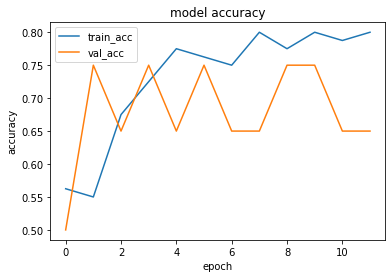

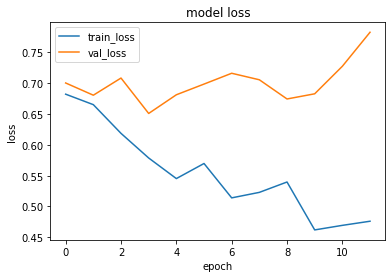

1it [00:00, 17260.51it/s]


prediction for video armflapping_1.mov is [[0.40127084]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_3.mov is [[0.67610204]]


1it [00:00, 18315.74it/s]


prediction for video armflapping_2.mov is [[0.7034879]]


1it [00:00, 19239.93it/s]


prediction for video control_1.mov is [[0.23202667]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.20249778]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.19705051]]
Epoch 1/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6791 - accuracy: 0.4375 - precision_61: 0.4655 - recall_61: 0.6585 - val_loss: 0.5750 - val_accuracy: 0.7500 - val_precision_61: 0.7000 - val_recall_61: 0.7778
Epoch 2/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6459 - accuracy: 0.7250 - precision_61: 0.7111 - recall_61: 0.7805 - val_loss: 0.6192 - val_accuracy: 0.6500 - val_precision_61: 0.7500 - val_recall_61: 0.3333
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6442 - accuracy: 0.6125 - precision_61: 0.6923 - recall_61: 0.4390 - val_loss: 0.6238 - val_accuracy: 0.7000 - val_precision_61: 0.6364 - val_recall_61: 0.7778
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6192 - accuracy: 0.7125 - precision_61: 0.7045 - recall_61: 0.7561 - val_loss: 0.5867 - val_accuracy: 0.7500 - val_precision_61: 0.7000 - val_recall_61: 0.7778
Epoch 5/75


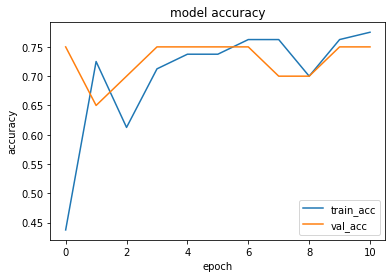

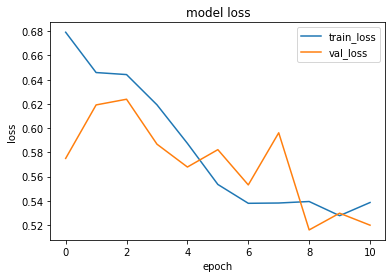

1it [00:00, 18808.54it/s]


prediction for video armflapping_1.mov is [[0.6130785]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.4862607]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_2.mov is [[0.69734776]]


1it [00:00, 17549.39it/s]


prediction for video control_1.mov is [[0.39169803]]


1it [00:00, 18236.10it/s]


prediction for video control_2.mov is [[0.2679245]]


1it [00:00, 16912.52it/s]

prediction for video control_3.mov is [[0.22080103]]


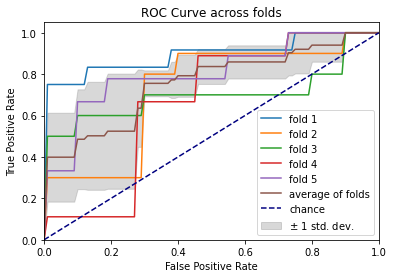

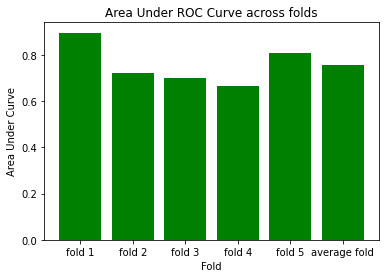

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.7370 - accuracy: 0.4750 - precision_63: 0.3750 - recall_63: 0.1579 - val_loss: 0.6475 - val_accuracy: 0.7000 - val_precision_63: 0.6875 - val_recall_63: 0.9167
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.7050 - accuracy: 0.5875 - precision_63: 0.5397 - recall_63: 0.8947 - val_loss: 0.5985 - val_accuracy: 0.6500 - val_precision_63: 0.6471 - val_recall_63: 0.9167
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6494 - accuracy: 0.6750 - precision_63: 0.6429 - recall_63: 0.7105 - val_loss: 0.6485 - val_accuracy: 0.7500 - val_precision_63: 1.0000 - val_recall_63: 0.5833
Epoch 4/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6533 - accuracy: 0.6000 - precision_63: 0.7500 - recall_63: 0.2368 - val_loss: 0.6346 - val_accuracy: 0.7000 - val_precision_63: 1.0000 - val_recall_63: 0.5000
Epoch 5/75
3/3 [==============================] - 0s 124ms/step 

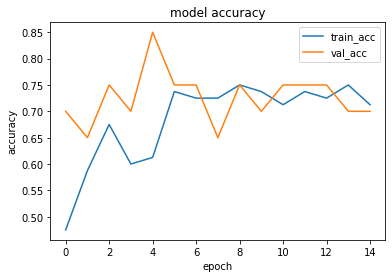

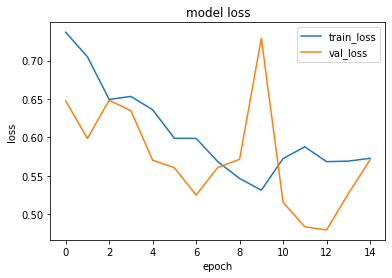

1it [00:00, 16644.06it/s]


prediction for video armflapping_1.mov is [[0.44950685]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_3.mov is [[0.5113607]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_2.mov is [[0.5378398]]


1it [00:00, 17260.51it/s]


prediction for video control_1.mov is [[0.35325366]]


1it [00:00, 17623.13it/s]


prediction for video control_2.mov is [[0.32432842]]


1it [00:00, 19239.93it/s]


prediction for video control_3.mov is [[0.33131993]]
Epoch 1/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6701 - accuracy: 0.5625 - precision_64: 0.5758 - recall_64: 0.4750 - val_loss: 0.6447 - val_accuracy: 0.5000 - val_precision_64: 0.5000 - val_recall_64: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6221 - accuracy: 0.6375 - precision_64: 0.5965 - recall_64: 0.8500 - val_loss: 0.6800 - val_accuracy: 0.7500 - val_precision_64: 0.7273 - val_recall_64: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6405 - accuracy: 0.7000 - precision_64: 0.7353 - recall_64: 0.6250 - val_loss: 0.6264 - val_accuracy: 0.7500 - val_precision_64: 0.7273 - val_recall_64: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 129ms/step - loss: 0.5914 - accuracy: 0.7250 - precision_64: 0.7045 - recall_64: 0.7750 - val_loss: 0.6208 - val_accuracy: 0.7500 - val_precision_64: 0.7273 - val_recall_64: 0.8000
Epoch 5/75


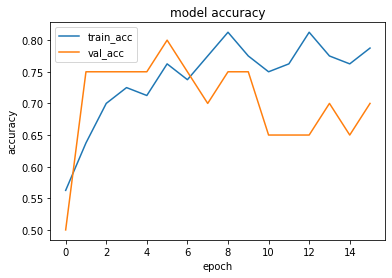

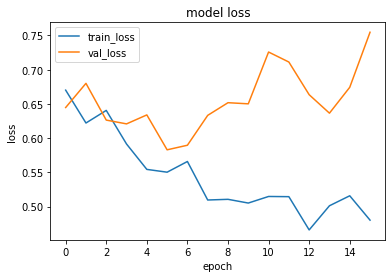

1it [00:00, 17549.39it/s]


prediction for video armflapping_1.mov is [[0.60170794]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_3.mov is [[0.4617274]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.69896686]]


1it [00:00, 17772.47it/s]


prediction for video control_1.mov is [[0.43033102]]


1it [00:00, 19972.88it/s]


prediction for video control_2.mov is [[0.32958126]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.27761978]]
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.7486 - accuracy: 0.4250 - precision_65: 0.3929 - recall_65: 0.2750 - val_loss: 0.6872 - val_accuracy: 0.7000 - val_precision_65: 0.7500 - val_recall_65: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6700 - accuracy: 0.7250 - precision_65: 0.6800 - recall_65: 0.8500 - val_loss: 0.6545 - val_accuracy: 0.7000 - val_precision_65: 0.7000 - val_recall_65: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6221 - accuracy: 0.7375 - precision_65: 0.6863 - recall_65: 0.8750 - val_loss: 0.6549 - val_accuracy: 0.6000 - val_precision_65: 0.7500 - val_recall_65: 0.3000
Epoch 4/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6824 - accuracy: 0.5625 - precision_65: 0.6316 - recall_65: 0.3000 - val_loss: 0.6159 - val_accuracy: 0.6500 - val_precision_65: 0.6364 - val_recall_65: 0.7000
Epoch 5/75


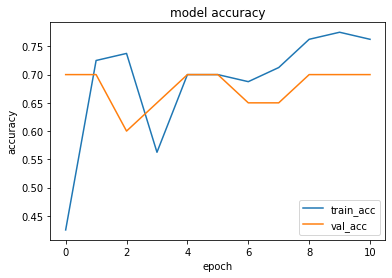

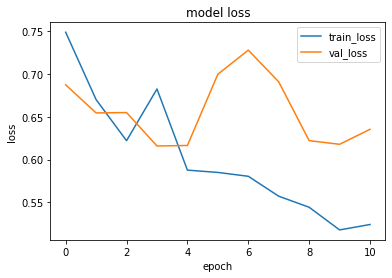

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.5932406]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.64267564]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_2.mov is [[0.6729131]]


1it [00:00, 18477.11it/s]


prediction for video control_1.mov is [[0.24941099]]


1it [00:00, 18558.87it/s]


prediction for video control_2.mov is [[0.24859592]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.24874991]]
Epoch 1/75
3/3 [==============================] - 0s 143ms/step - loss: 0.7021 - accuracy: 0.5375 - precision_66: 0.5333 - recall_66: 0.7805 - val_loss: 0.6723 - val_accuracy: 0.5500 - val_precision_66: 0.5000 - val_recall_66: 0.4444
Epoch 2/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6421 - accuracy: 0.6750 - precision_66: 0.7778 - recall_66: 0.5122 - val_loss: 0.6790 - val_accuracy: 0.5000 - val_precision_66: 0.4737 - val_recall_66: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6751 - accuracy: 0.5625 - precision_66: 0.5429 - recall_66: 0.9268 - val_loss: 0.7073 - val_accuracy: 0.7500 - val_precision_66: 0.6667 - val_recall_66: 0.8889
Epoch 4/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6169 - accuracy: 0.7125 - precision_66: 0.7045 - recall_66: 0.7561 - val_loss: 0.6540 - val_accuracy: 0.6500 - val_precision_66: 0.6250 - val_recall_66: 0.5556
Epoch 5/75


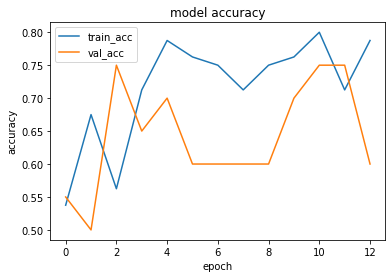

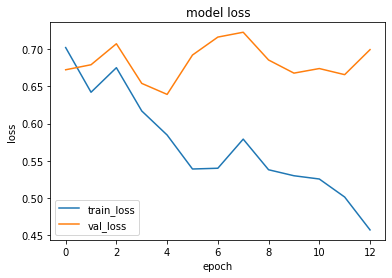

1it [00:00, 18477.11it/s]


prediction for video armflapping_1.mov is [[0.39650562]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.6129327]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_2.mov is [[0.6142126]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.3408927]]


1it [00:00, 18558.87it/s]


prediction for video control_2.mov is [[0.29425967]]


1it [00:00, 14027.77it/s]


prediction for video control_3.mov is [[0.24599993]]
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6902 - accuracy: 0.5125 - precision_67: 0.5185 - recall_67: 0.6829 - val_loss: 0.6686 - val_accuracy: 0.4500 - val_precision_67: 0.4500 - val_recall_67: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6594 - accuracy: 0.5375 - precision_67: 0.5345 - recall_67: 0.7561 - val_loss: 0.5947 - val_accuracy: 0.7500 - val_precision_67: 0.7000 - val_recall_67: 0.7778
Epoch 3/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6173 - accuracy: 0.7000 - precision_67: 0.6667 - recall_67: 0.8293 - val_loss: 0.5652 - val_accuracy: 0.6500 - val_precision_67: 0.6000 - val_recall_67: 0.6667
Epoch 4/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6171 - accuracy: 0.7000 - precision_67: 0.7576 - recall_67: 0.6098 - val_loss: 0.5552 - val_accuracy: 0.7500 - val_precision_67: 0.7000 - val_recall_67: 0.7778
Epoch 5/75


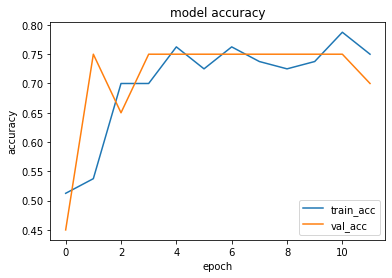

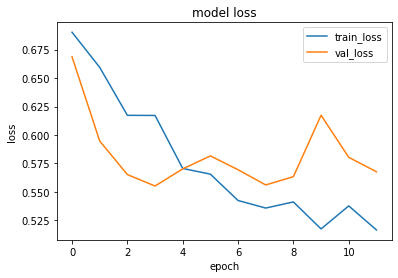

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.6955891]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_3.mov is [[0.72467077]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_2.mov is [[0.76258945]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.50230205]]


1it [00:00, 17549.39it/s]


prediction for video control_2.mov is [[0.39422047]]


1it [00:00, 18157.16it/s]

prediction for video control_3.mov is [[0.3360291]]


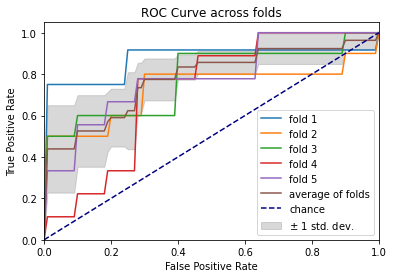

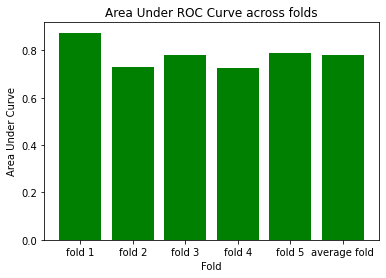

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

Epoch 1/75
3/3 [==============================] - 1s 201ms/step - loss: 0.7237 - accuracy: 0.4500 - precision_69: 0.4062 - recall_69: 0.3421 - val_loss: 0.6305 - val_accuracy: 0.6000 - val_precision_69: 0.6000 - val_recall_69: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6834 - accuracy: 0.6000 - precision_69: 0.5469 - recall_69: 0.9211 - val_loss: 0.6166 - val_accuracy: 0.6500 - val_precision_69: 0.6471 - val_recall_69: 0.9167
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6340 - accuracy: 0.6875 - precision_69: 0.6383 - recall_69: 0.7895 - val_loss: 0.6267 - val_accuracy: 0.7000 - val_precision_69: 0.7143 - val_recall_69: 0.8333
Epoch 4/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6155 - accuracy: 0.7125 - precision_69: 0.6923 - recall_69: 0.7105 - val_loss: 0.5873 - val_accuracy: 0.7500 - val_precision_69: 0.8182 - val_recall_69: 0.7500
Epoch 5/75
3/3 [==============================] - 0s 126ms/step 

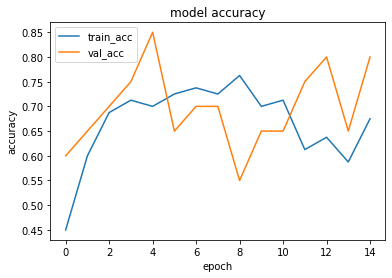

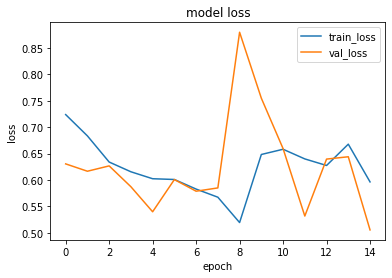

1it [00:00, 18236.10it/s]


prediction for video armflapping_1.mov is [[0.1613546]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.50631464]]


1it [00:00, 16912.52it/s]


prediction for video armflapping_2.mov is [[0.5116568]]


1it [00:00, 18477.11it/s]


prediction for video control_1.mov is [[0.1363523]]


1it [00:00, 18477.11it/s]


prediction for video control_2.mov is [[0.1294977]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.12917542]]
Epoch 1/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6672 - accuracy: 0.5625 - precision_70: 0.5439 - recall_70: 0.7750 - val_loss: 0.7020 - val_accuracy: 0.5500 - val_precision_70: 0.5294 - val_recall_70: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6924 - accuracy: 0.6125 - precision_70: 0.5692 - recall_70: 0.9250 - val_loss: 0.6552 - val_accuracy: 0.7500 - val_precision_70: 0.7273 - val_recall_70: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6320 - accuracy: 0.7000 - precision_70: 0.7667 - recall_70: 0.5750 - val_loss: 0.7012 - val_accuracy: 0.7000 - val_precision_70: 0.7500 - val_recall_70: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6073 - accuracy: 0.7500 - precision_70: 0.8125 - recall_70: 0.6500 - val_loss: 0.6529 - val_accuracy: 0.7000 - val_precision_70: 0.6667 - val_recall_70: 0.8000
Epoch 5/75


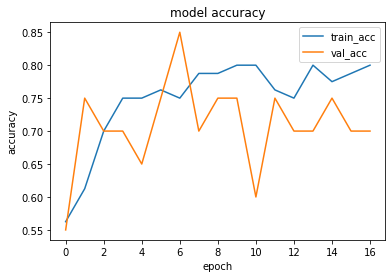

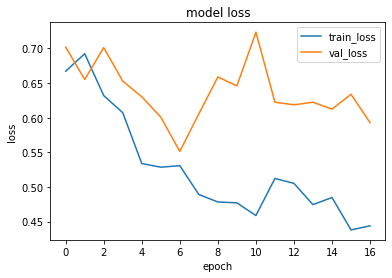

1it [00:00, 18236.10it/s]


prediction for video armflapping_1.mov is [[0.40609375]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.6091194]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.46197912]]


1it [00:00, 17476.27it/s]


prediction for video control_1.mov is [[0.3041519]]


1it [00:00, 17189.77it/s]


prediction for video control_2.mov is [[0.29646003]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.29399037]]
Epoch 1/75
3/3 [==============================] - 0s 141ms/step - loss: 0.7302 - accuracy: 0.5750 - precision_71: 0.5484 - recall_71: 0.8500 - val_loss: 0.6729 - val_accuracy: 0.6000 - val_precision_71: 1.0000 - val_recall_71: 0.2000
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6403 - accuracy: 0.6625 - precision_71: 0.7600 - recall_71: 0.4750 - val_loss: 0.6265 - val_accuracy: 0.6500 - val_precision_71: 0.6364 - val_recall_71: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6101 - accuracy: 0.7250 - precision_71: 0.6800 - recall_71: 0.8500 - val_loss: 0.6120 - val_accuracy: 0.7000 - val_precision_71: 0.7000 - val_recall_71: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 128ms/step - loss: 0.5622 - accuracy: 0.7125 - precision_71: 0.6667 - recall_71: 0.8500 - val_loss: 0.6248 - val_accuracy: 0.7000 - val_precision_71: 0.7500 - val_recall_71: 0.6000
Epoch 5/75


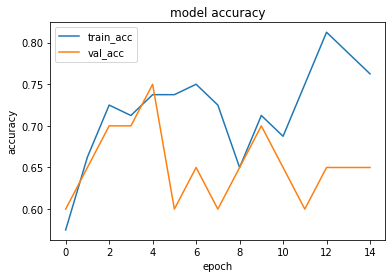

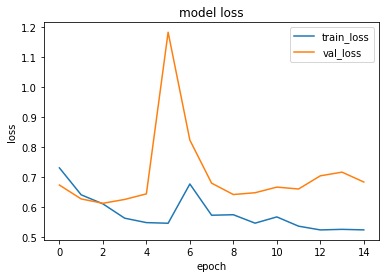

1it [00:00, 19239.93it/s]


prediction for video armflapping_1.mov is [[0.46773604]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_3.mov is [[0.6585245]]


1it [00:00, 16448.25it/s]


prediction for video armflapping_2.mov is [[0.6059741]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.42570806]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.44070262]]


1it [00:00, 18893.26it/s]


prediction for video control_3.mov is [[0.4380926]]
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6682 - accuracy: 0.6500 - precision_72: 0.6585 - recall_72: 0.6585 - val_loss: 0.6764 - val_accuracy: 0.6000 - val_precision_72: 0.5333 - val_recall_72: 0.8889
Epoch 2/75
3/3 [==============================] - 0s 122ms/step - loss: 0.5935 - accuracy: 0.7125 - precision_72: 0.6667 - recall_72: 0.8780 - val_loss: 0.6077 - val_accuracy: 0.7500 - val_precision_72: 0.7000 - val_recall_72: 0.7778
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.5605 - accuracy: 0.7500 - precision_72: 0.7561 - recall_72: 0.7561 - val_loss: 0.7788 - val_accuracy: 0.6000 - val_precision_72: 0.5556 - val_recall_72: 0.5556
Epoch 4/75
3/3 [==============================] - 0s 127ms/step - loss: 0.5853 - accuracy: 0.7000 - precision_72: 0.7297 - recall_72: 0.6585 - val_loss: 0.7509 - val_accuracy: 0.6500 - val_precision_72: 0.6000 - val_recall_72: 0.6667
Epoch 5/75
3

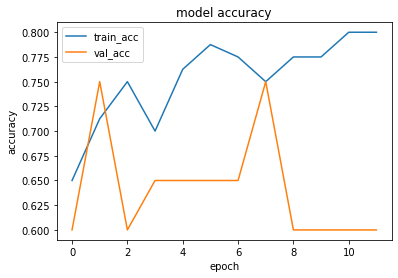

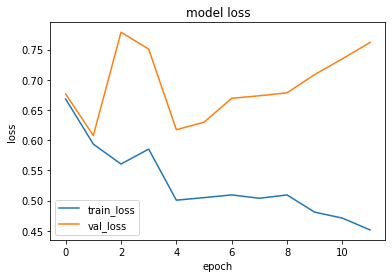

1it [00:00, 13357.66it/s]


prediction for video armflapping_1.mov is [[0.35050666]]


1it [00:00, 16320.25it/s]


prediction for video armflapping_3.mov is [[0.6697284]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_2.mov is [[0.7233748]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.2257061]]


1it [00:00, 17260.51it/s]


prediction for video control_2.mov is [[0.22360447]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.22224703]]
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6921 - accuracy: 0.4500 - precision_73: 0.4746 - recall_73: 0.6829 - val_loss: 0.6125 - val_accuracy: 0.7500 - val_precision_73: 0.7000 - val_recall_73: 0.7778
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6808 - accuracy: 0.6375 - precision_73: 0.6364 - recall_73: 0.6829 - val_loss: 0.5727 - val_accuracy: 0.7000 - val_precision_73: 0.6667 - val_recall_73: 0.6667
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6301 - accuracy: 0.7250 - precision_73: 0.7436 - recall_73: 0.7073 - val_loss: 0.5789 - val_accuracy: 0.7000 - val_precision_73: 0.6364 - val_recall_73: 0.7778
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.5923 - accuracy: 0.7125 - precision_73: 0.6875 - recall_73: 0.8049 - val_loss: 0.6389 - val_accuracy: 0.7500 - val_precision_73: 0.7000 - val_recall_73: 0.7778
Epoch 5/75


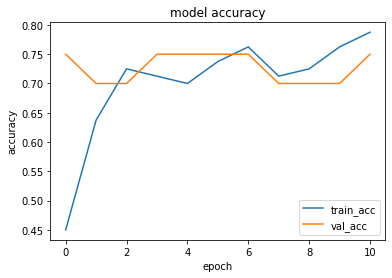

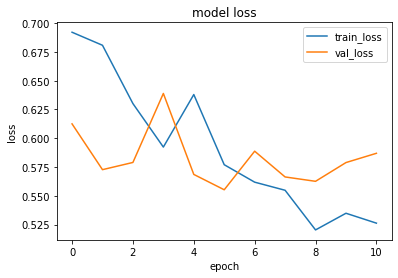

1it [00:00, 18477.11it/s]


prediction for video armflapping_1.mov is [[0.5935118]]


1it [00:00, 16644.06it/s]


prediction for video armflapping_3.mov is [[0.731525]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.7808716]]


1it [00:00, 18893.26it/s]


prediction for video control_1.mov is [[0.15701246]]


1it [00:00, 15592.21it/s]


prediction for video control_2.mov is [[0.13164055]]


1it [00:00, 17260.51it/s]


prediction for video control_3.mov is [[0.12548992]]


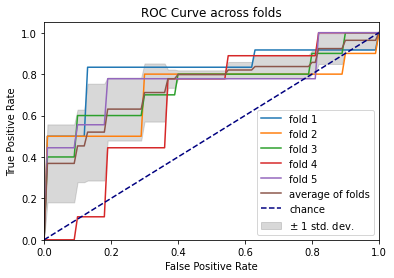

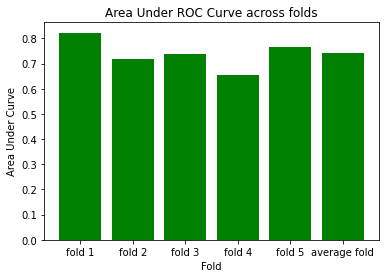

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping])

In [ ]:
len(AVERAGE_TPRS)